In [2]:
from gan import Generator, Discriminator, Features, SignalHead, DeconvHead
from hierarchical_negbin import RecordGenerator

import os
import pdb
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)
cols = ["#926cb6", "#93b793", "#d31d00", "#ff900d", "#fefb03", "black"]
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
first_run = True

In [4]:
MAXBINS = 400
BATCHSIZE = 48  # max size is 64

In [5]:
simulator = RecordGenerator(n_obs=(10000, 10000),
                            n_bins=(50, MAXBINS),
                            n_meanings=(1, 4),
                            noise_ratio=(0.05, 0.1),
                            noise_dispersion=(0.05, 1.5),
                            alpha_meanings=(1.0, 4.0),
                            rounding=[1],
                            inner_mode_dist_tol=0.2,
                            inner_sigma_ratio=3.0,
                            max_sigma_to_bins_ratio=0.2,
                            sigmas=(0.5, 100.0),
                            trim_corners=False)

In [6]:
geninput_noise = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)
geninput_signal = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)
geninput_noiseratio = tf.keras.Input(shape=(1, 1), dtype=tf.float32)
disinput = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)

genoutput = Generator(ksize=5, filters=48, nblocks=16, batch_norms=False)([geninput_noise, geninput_signal, geninput_noiseratio])
disoutput = Discriminator(ksize=7, filters=32, nblocks=16, batch_norms=False)(disinput)

generator = tf.keras.Model(inputs=[geninput_noise, geninput_signal, geninput_noiseratio], outputs=genoutput)
discriminator = tf.keras.Model(inputs=disinput, outputs=disoutput)

inputs_smoother = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)
inputs_deconv = tf.keras.Input(shape=(MAXBINS, 2), dtype=tf.float32)

feats_smoother = Features(ksize=7, filters=32, nblocks=12, batch_norms=False)(inputs_smoother)
feats_deconv = Features(ksize=7, filters=32, nblocks=12, batch_norms=False)(inputs_deconv)

signal_head = SignalHead(ksize=5, filters=32, nblocks_signal=2, nblocks_peaks=4, batch_norms=False)
deconv_head =  DeconvHead(ksize=5, filters=32, nblocks=4, batch_norms=False)

signal, peaks = signal_head([feats_smoother, inputs_smoother])
deconv = deconv_head([feats_deconv, inputs_deconv])

smoother = tf.keras.Model(inputs=inputs_smoother, outputs=[signal, peaks])
deconv = tf.keras.Model(inputs=inputs_deconv, outputs=deconv)

In [7]:
# generator.load_weights("generator.h5")
# discriminator.load_weights("discriminator.h5")
smoother.load_weights("smoother_post_gan2.h5")
deconv.load_weights("deconv_post_gan2.h5")
generator.load_weights("ckpts/generator_0125.h5")
discriminator.load_weights("ckpts/discriminator_0125.h5")
# smoother.load_weights("ckpts/smoother_0040.h5")
# generator.load_weights("ckpts/generator_0104.h5")
# discriminator.load_weights("ckpts/discriminator_0104.h5")
# smoother.load_weights("ckpts/smoother_0104.h5")
# deconvolver.load_weights("deconvolver.h5")
# smoother.load_weights("tmp_back_to_two_smoother.h5")

In [8]:
# generator.summary(line_length=150)

In [9]:
# discriminator.summary(line_length=150)

In [10]:
def standardize_bins(obs):
    if len(obs) > MAXBINS:
        start = (len(obs) - MAXBINS) // 2
        obs = obs[start:(start + MAXBINS)]
    L = len(obs)
    assert L <= MAXBINS
    start = MAXBINS // 2 - L // 2
    end = start + L
    out = np.zeros(MAXBINS, dtype=type(obs[0]))
    out[start:end] = obs
    return out, start


def get_inputs(batch_raw):
    batch = [x['counts'] for x in batch_raw]
    bin_sizes_stacked = []
    noises = []
    signals = []
    signals_stacked = []
    real_obs = []
    real_obs_stacked = []
    modes = []
    modes_stacked = []
    nr = []
    bin_sizes = []
    num_meanings = []
#     generated_images = []
#     generated_images_stacked = []
    for j, obs in enumerate(batch):
        n = len(obs)
        x = np.array(obs, dtype=np.float32)
        x = np.maximum(x - 2.0, 0.0)
        x /= x.sum()
        if np.any(np.isnan(x)):
            print("Warning: not enough counts on x, skipping...")
            continue
        x, start_bin = standardize_bins(x)
        z = np.random.normal(size=n).astype(np.float32)
        z, _ = standardize_bins(z)
        while True:
            try:
                dat = simulator.generate(n_bins=n)
                break
            except RuntimeError as e:
                print("error with ", n, "bins")
                print(e)             
        pdf = dat['pdf'].astype(np.float32)
        pdf -= pdf.min()
        pdf /= pdf.sum()
        pdf, _ = standardize_bins(pdf)
        if np.any(np.isnan(pdf)):
            pdb.set_trace()
        m = dat['centroids_onehot']
        m, _ = standardize_bins(m)
        meaning_modes = dat['meaning_centroids']
        meaning_modes = [int(np.round(np.clip(x, 0, n - 1))) for x in meaning_modes]
#         print(meaning_modes)
        meaning_pdfs = dat['meaning_pdfs']
        Nm = len(meaning_modes)
        pdfm_stacked = np.zeros((Nm, MAXBINS), dtype=np.float32)
        m_stacked = np.zeros((Nm, MAXBINS), dtype=np.float32)
        for l, (mm, d) in enumerate(zip(meaning_modes, meaning_pdfs)):
            u = np.zeros(n, dtype=np.float32)
            u[mm] = 1.0
            m_stacked[l, :] = standardize_bins(u)[0]
            #
            d = d.astype(np.float32)
            d -= d.min()
            d /= d.sum()
            pdfm_stacked[l, :] = standardize_bins(d)[0]
        nr0 = np.random.uniform(0.1, 0.75)
        nr.append(nr0)
        modes.append(m)
        noises.append(z)
        signals.append(pdf)
        real_obs.append(x)
        bin_sizes.append(n)
        modes_stacked.append(m_stacked)
        real_obs_stacked.append(np.stack(Nm * [x], 0))
        bin_sizes_stacked.append(Nm * [n])
        num_meanings.append(Nm)
        signals_stacked.append(pdfm_stacked)
#         z_max = np.reshape(z, (1, -1, 1))
#         pdf_max = np.reshape(pdf, (1, -1, 1)) * n
#         nr_max = np.reshape(nr0, (1, 1, 1)).astype(np.float32)
#         gi = generator([z_max, pdf_max, nr_max])
#         generated_images.append(gi)
#         gi_s = np.concatenate(Nm * [gi], 0)
#         generated_images_stacked.append(gi_s)
    noises = np.stack(noises, 0)       
    noises = np.expand_dims(noises, -1)
    signals = np.stack(signals, 0)       
    signals = np.expand_dims(signals, -1)
    modes = np.stack(modes, 0)       
    modes = np.expand_dims(modes, -1)
    real_obs = np.stack(real_obs, 0)       
    real_obs = np.expand_dims(real_obs, -1)
    bin_sizes = np.reshape(np.array(bin_sizes, dtype=np.float32), (-1, 1, 1))
    real_obs_stacked = np.expand_dims(np.concatenate(real_obs_stacked, 0), -1)
    signals_stacked = np.expand_dims(np.concatenate(signals_stacked, 0), -1)
    modes_stacked = np.expand_dims(np.concatenate(modes_stacked, 0), -1)
    bin_sizes_stacked = np.reshape(np.concatenate(bin_sizes_stacked, 0), (-1, 1, 1))
#     generated_images = np.concatenate(generated_images, 0)
#     generated_images_stacked = np.concatenate(generated_images_stacked, 0)
    nr = np.reshape(np.array(nr, dtype=np.float32), (-1, 1, 1))
    #
    pdf_max = signals * bin_sizes
    generated_images = generator([noises, pdf_max, nr]).numpy()
    generated_images_stacked = []
    for k, Nm in enumerate(num_meanings):
        gi_k = generated_images[k,:,:]
        gi_k = np.stack(Nm * [gi_k], 0)
        generated_images_stacked.append(gi_k)
    generated_images_stacked = np.concatenate(generated_images_stacked, 0)
    #
    return real_obs, noises, signals, nr, modes, bin_sizes, real_obs_stacked, signals_stacked, modes_stacked, bin_sizes_stacked, num_meanings, generated_images, generated_images_stacked


def read_batch(file):
    with open(file, "r") as f:
        x = json.load(f)
    return x

In [11]:
cross_entropy_from_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def binary_loss(y, phat):
    #
    loss = - 2.5 * y * tf.math.log(phat + 1e-12)
    loss += - (1.0 - y) * tf.math.log(1.0 - phat + 1e-12)
    loss = tf.math.reduce_mean(tf.math.reduce_sum(loss, 1))
    return loss

    
def num_meanings_loss(num_meanings, phat):
    phat_sum = tf.math.reduce_sum(phat, 1)
    loss = tf.math.reduce_mean((phat_sum - num_meanings) ** 2)
    return loss
    

def tv_reg(x):
    x0 = x[:,:-1,:]
    x1 = x[:,1:,:]
    d0 = tf.reduce_mean(tf.reduce_sum((x1 - x0)**2, 1))
    #
    z = (x1 - x0)
    z0 = z[:,:-1,:]
    z1 = z[:,1:,:]
    d1 = tf.reduce_mean(tf.reduce_sum((z1 - z0)**2, 1))
    #
    return d0 + 0.25 * d1


def skl(y, yhat):
    x = - 0.5 * y * tf.math.log((yhat + 1e-6) / (y + 1e-6))
    x += - 0.5 * yhat * tf.math.log((y + 1e-6) / (yhat + 1e-6))
    loss = tf.reduce_mean(tf.math.reduce_sum(x, 1))
    return loss


smoother_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.75, clipnorm=3.0)
deconv_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.75, clipnorm=3.0)


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function(experimental_relax_shapes=True)
def train_step(real_signal, noise, pdf, nr, modes, bin_sizes, generated_images, num_meanings,
               real_signals_stacked, pdfs_stacked, modes_stacked, bin_sizes_stacked, generated_images_stacked):
    # normalization
    pdf_normalized = pdf * bin_sizes
    real_signal_normalized = real_signal * bin_sizes
    real_signals_stacked_normalized = real_signals_stacked * bin_sizes_stacked
    pdfs_stacked_normalized = pdfs_stacked * bin_sizes_stacked
    
    # generate fake images
    generated_images_normalized = generated_images * bin_sizes
    generated_images_stacked_normalized = generated_images_stacked * bin_sizes_stacked
    
    # compute smoother loss      
    with tf.GradientTape() as sm_tape, tf.GradientTape() as sm_tape_robust_opt:
        # 
        sm_tape_robust_opt.watch(generated_images_normalized)
        smooth_fake, peaks_fake = smoother(generated_images_normalized)
        smooth_real, peaks_real = smoother(real_signal_normalized)
        #
        sm_loss = skl(pdf, smooth_fake)
        peaks_fake_phat = tf.math.sigmoid(peaks_fake)
        peaks_loss = 0.1 * binary_loss(modes, peaks_fake_phat)
        meanings_loss = num_meanings_loss(num_meanings, peaks_fake_phat)
        sm_loss += peaks_loss + meanings_loss
#         sm_reg = 0.05 * tv_reg(smooth_fake)
#         sm_reg += 0.001 * tv_reg(peaks_fake)
        sm_reg = 1.0 * tv_reg(smooth_real)
#         sm_reg += 0.00001 * tv_reg(peaks_real)
        sm_reg += 0.0001 * sum(generator.losses)
        sm_loss += sm_reg
        
        data_grad = sm_tape_robust_opt.gradient(sm_loss, [generated_images_normalized])[0]
        robust_opt_penalty = 1e-6 * tf.reduce_mean(tf.reduce_sum(data_grad ** 2, 1))
        sm_loss += robust_opt_penalty

    # compute and apply gradients
    gradients_of_smoother = sm_tape.gradient(sm_loss, smoother.trainable_variables)    
    smooth_check_disc = [tf.debugging.check_numerics(d, "smoother grad") for d in gradients_of_smoother]
    with tf.control_dependencies(smooth_check_disc):
        smoother_optimizer.apply_gradients(zip(gradients_of_smoother, smoother.trainable_variables))
        
    # compute deconv loss    
    with tf.GradientTape() as deconv_tape, tf.GradientTape() as deconv_tape_robust_opt:
        deconv_tape_robust_opt.watch(generated_images_stacked_normalized)
        deconv_inputs_generated = tf.concat([generated_images_stacked_normalized, modes_stacked], -1)
        deconv_output = deconv(deconv_inputs_generated)
        deconv_loss = skl(pdfs_stacked_normalized, deconv_output)
        deconv_reg = 0.5 * tv_reg(deconv_output)
        deconv_reg += 0.0001 * sum(deconv.losses)
        deconv_loss += deconv_reg
        
        data_grad = deconv_tape_robust_opt.gradient(deconv_loss, [generated_images_stacked_normalized])[0]
        robust_opt_penalty_deconv = 1e-6 * tf.reduce_mean(tf.reduce_sum(data_grad ** 2, 1))
        deconv_loss += robust_opt_penalty_deconv
        
    # compute and apply gradients
    gradients_of_deconv = deconv_tape.gradient(deconv_loss, deconv.trainable_variables)
    deconv_check_disc = [tf.debugging.check_numerics(d, "deconv grad") for d in gradients_of_deconv]
    with tf.control_dependencies(deconv_check_disc):
        deconv_optimizer.apply_gradients(zip(gradients_of_deconv, deconv.trainable_variables))
        
   

    return sm_loss, deconv_loss, sm_reg, deconv_reg, peaks_loss, meanings_loss, robust_opt_penalty

In [12]:
def print_checks(model, prefix=""):
    # --- do some checks ---
    wts = model.get_weights()
    Mw = max(x.max() for x in wts)
    mw = min(x.min() for x in wts)
#     means = []
#     varis = []
#     for w in model.weights:
#         if "moving_mean" in w.name:
#             means.append(w.numpy().mean())
#         if "moving_var" in w.name:
#             varis.append(w.numpy().mean())
#     means = np.mean(means)
#     stds = np.sqrt(np.mean(varis))
    wnames = []
    for w in model.weights:
        if np.any(np.isnan(w.numpy())):
            wnames.append(w.name)
    if len(wnames) > 0:
            print(f"{prefix} | nans at: ", wnames)
#     print(f"{prefix} | wts: ({mw:.2f}, {Mw:.2f}) | mov_means: {means:.2f}, mov_stds: {stds:.4f}")
    print(f"{prefix} | wts: ({mw:.2f}, {Mw:.2f})")

In [13]:
fdir = "../SmoothDoQ/doq_noun_batches/"
files = os.listdir(fdir)
files = [os.path.join(fdir, x) for x in files]

===== Epoch 0: =====
iter: 0, completed: 0.03%, smoother_loss: 0.9629, deconv_loss: 518.3914, smoother_reg: 0.0117, deconv_reg: 0.0178, peaks_loss: 0.7762, mn_loss: 0.0876, ro_pen: 0.0101
Smother | wts: (-14.58, 2.32)
Deconv | wts: (-4.73, 1.37)


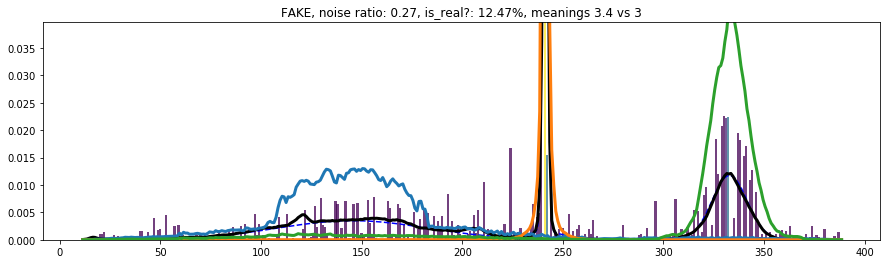

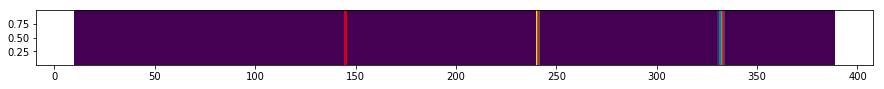

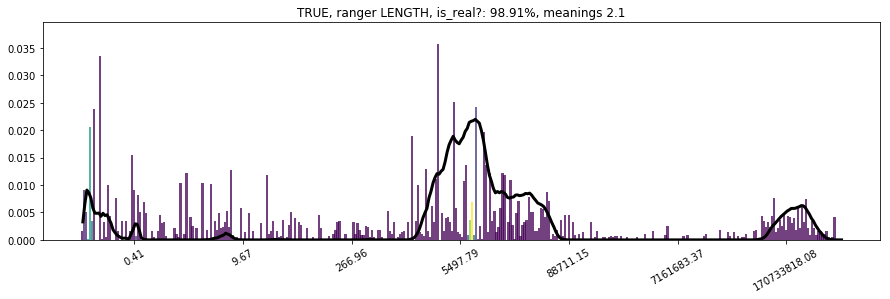

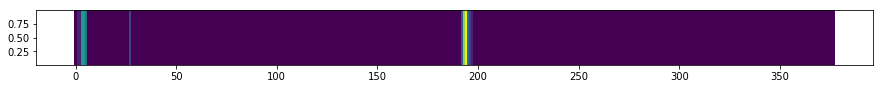

error with  428 bins
iter: 5, completed: 0.19%, smoother_loss: 0.9638, deconv_loss: 493.0332, smoother_reg: 0.0116, deconv_reg: 0.0180, peaks_loss: 0.7740, mn_loss: 0.0883, ro_pen: 0.0103
Smother | wts: (-14.58, 2.32)
Deconv | wts: (-4.74, 1.37)
iter: 10, completed: 0.34%, smoother_loss: 0.9787, deconv_loss: 468.9318, smoother_reg: 0.0113, deconv_reg: 0.0182, peaks_loss: 0.7826, mn_loss: 0.0913, ro_pen: 0.0106
Smother | wts: (-14.58, 2.32)
Deconv | wts: (-4.74, 1.37)
error with  311 bins
iter: 15, completed: 0.50%, smoother_loss: 0.9873, deconv_loss: 446.0061, smoother_reg: 0.0113, deconv_reg: 0.0182, peaks_loss: 0.7871, mn_loss: 0.0931, ro_pen: 0.0107
Smother | wts: (-14.58, 2.32)
Deconv | wts: (-4.74, 1.37)
iter: 20, completed: 0.66%, smoother_loss: 0.9979, deconv_loss: 424.2062, smoother_reg: 0.0110, deconv_reg: 0.0182, peaks_loss: 0.7909, mn_loss: 0.0965, ro_pen: 0.0110
Smother | wts: (-14.58, 2.32)
Deconv | wts: (-4.74, 1.37)
error with  312 bins
error with  318 bins
iter: 25, com

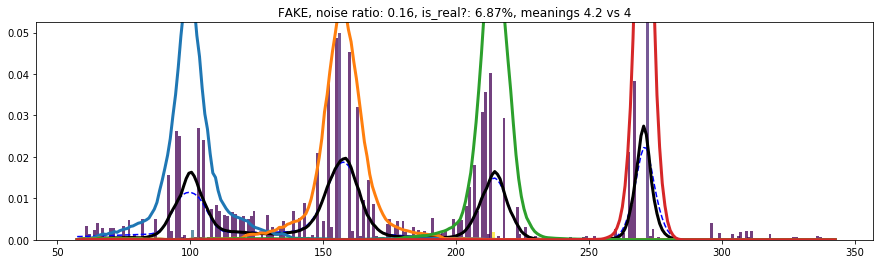

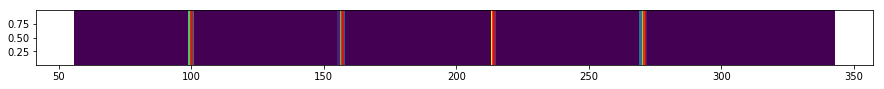

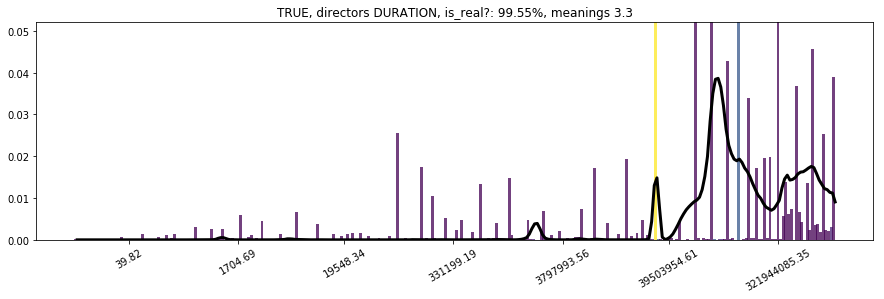

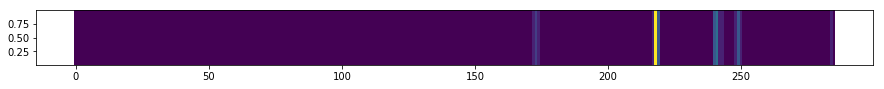

iter: 30, completed: 0.97%, smoother_loss: 1.0103, deconv_loss: 383.7523, smoother_reg: 0.0105, deconv_reg: 0.0182, peaks_loss: 0.7962, mn_loss: 0.0975, ro_pen: 0.0113
Smother | wts: (-14.57, 2.32)
Deconv | wts: (-4.74, 1.37)
iter: 35, completed: 1.13%, smoother_loss: 1.0132, deconv_loss: 364.9971, smoother_reg: 0.0103, deconv_reg: 0.0182, peaks_loss: 0.7969, mn_loss: 0.0975, ro_pen: 0.0113
Smother | wts: (-14.57, 2.32)
Deconv | wts: (-4.74, 1.37)
error with  413 bins
iter: 40, completed: 1.28%, smoother_loss: 1.0137, deconv_loss: 347.1588, smoother_reg: 0.0101, deconv_reg: 0.0180, peaks_loss: 0.7962, mn_loss: 0.0973, ro_pen: 0.0114
Smother | wts: (-14.57, 2.32)
Deconv | wts: (-4.74, 1.37)
iter: 45, completed: 1.44%, smoother_loss: 1.0213, deconv_loss: 330.2019, smoother_reg: 0.0099, deconv_reg: 0.0181, peaks_loss: 0.7984, mn_loss: 0.0995, ro_pen: 0.0114
Smother | wts: (-14.57, 2.31)
Deconv | wts: (-4.74, 1.37)
error with  423 bins
error with  426 bins
iter: 50, completed: 1.60%, smoot

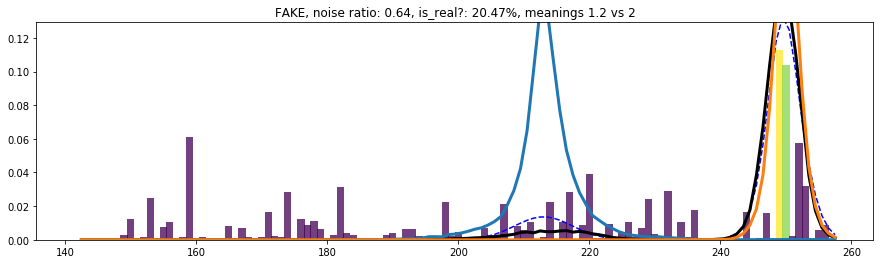

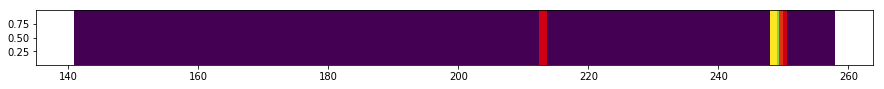

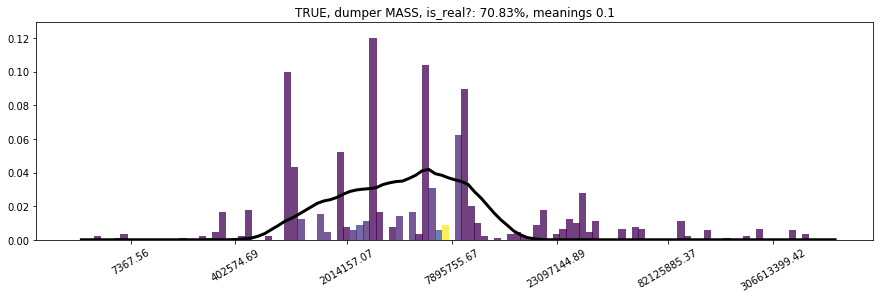

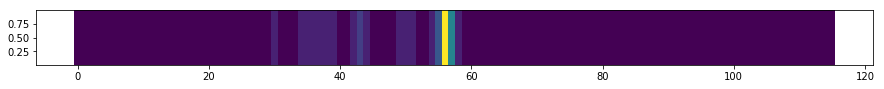

error with  367 bins
iter: 55, completed: 1.75%, smoother_loss: 1.0365, deconv_loss: 298.7415, smoother_reg: 0.0097, deconv_reg: 0.0180, peaks_loss: 0.8026, mn_loss: 0.1039, ro_pen: 0.0120
Smother | wts: (-14.57, 2.32)
Deconv | wts: (-4.74, 1.37)
iter: 60, completed: 1.91%, smoother_loss: 1.0458, deconv_loss: 284.1603, smoother_reg: 0.0096, deconv_reg: 0.0181, peaks_loss: 0.8053, mn_loss: 0.1052, ro_pen: 0.0124
Smother | wts: (-14.57, 2.31)
Deconv | wts: (-4.74, 1.37)
error with  270 bins
error with  456 bins
iter: 65, completed: 2.07%, smoother_loss: 1.0509, deconv_loss: 270.2900, smoother_reg: 0.0096, deconv_reg: 0.0184, peaks_loss: 0.8054, mn_loss: 0.1067, ro_pen: 0.0128
Smother | wts: (-14.57, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 70, completed: 2.22%, smoother_loss: 1.0530, deconv_loss: 257.0966, smoother_reg: 0.0096, deconv_reg: 0.0185, peaks_loss: 0.8059, mn_loss: 0.1062, ro_pen: 0.0130
Smother | wts: (-14.57, 2.31)
Deconv | wts: (-4.74, 1.37)
error with  291 bins
iter: 75, co

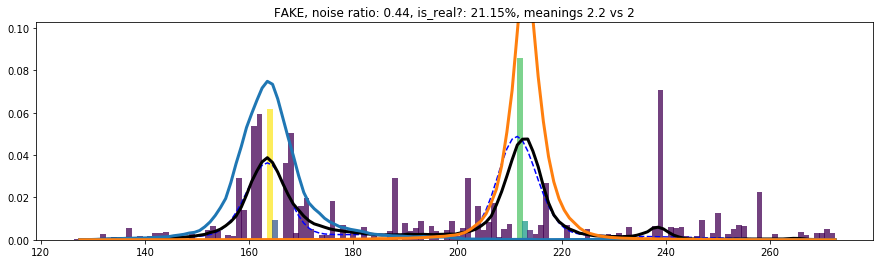

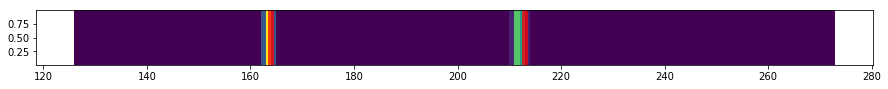

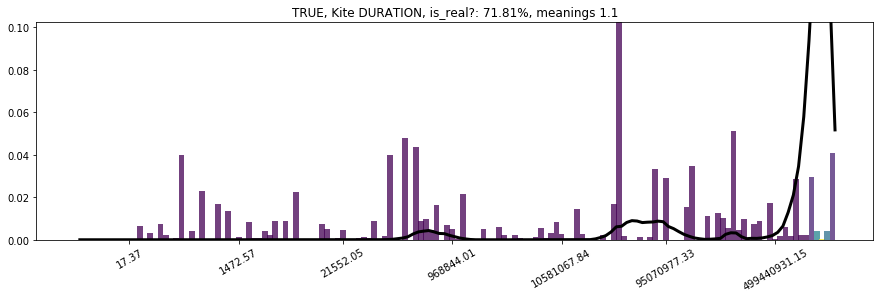

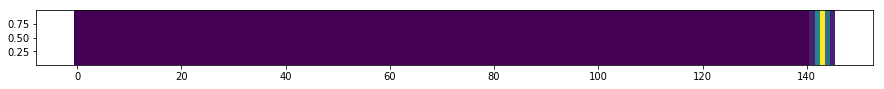

error with  232 bins
iter: 80, completed: 2.53%, smoother_loss: 1.0566, deconv_loss: 232.6179, smoother_reg: 0.0096, deconv_reg: 0.0186, peaks_loss: 0.8069, mn_loss: 0.1058, ro_pen: 0.0128
Smother | wts: (-14.56, 2.31)
Deconv | wts: (-4.74, 1.37)
error with  429 bins
iter: 85, completed: 2.69%, smoother_loss: 1.0499, deconv_loss: 221.2624, smoother_reg: 0.0095, deconv_reg: 0.0184, peaks_loss: 0.8018, mn_loss: 0.1039, ro_pen: 0.0125
Smother | wts: (-14.56, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 90, completed: 2.85%, smoother_loss: 1.0511, deconv_loss: 210.4710, smoother_reg: 0.0096, deconv_reg: 0.0184, peaks_loss: 0.8023, mn_loss: 0.1034, ro_pen: 0.0124
Smother | wts: (-14.56, 2.31)
Deconv | wts: (-4.74, 1.37)
error with  248 bins
iter: 95, completed: 3.00%, smoother_loss: 1.0462, deconv_loss: 200.2024, smoother_reg: 0.0095, deconv_reg: 0.0186, peaks_loss: 0.7985, mn_loss: 0.1025, ro_pen: 0.0122
Smother | wts: (-14.56, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 100, completed: 3.16%, smoo

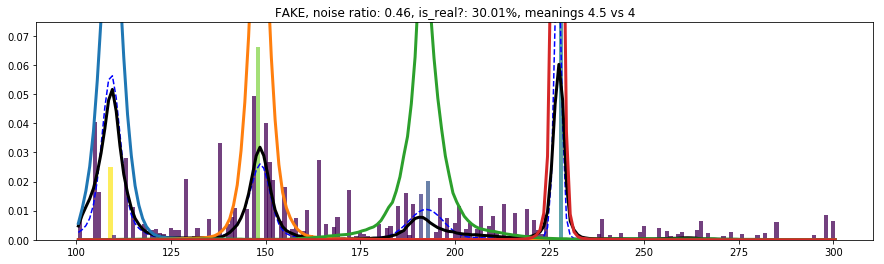

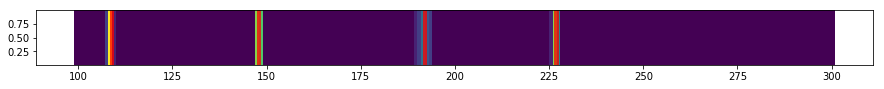

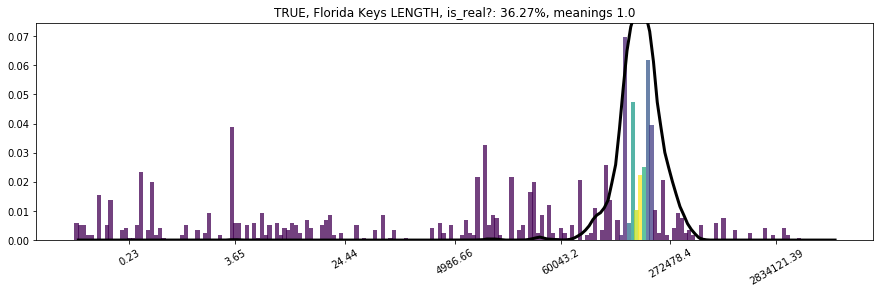

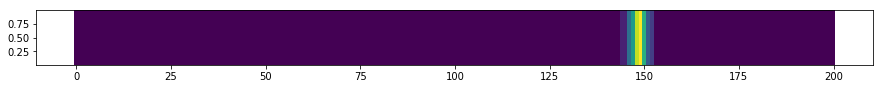

error with  420 bins
error with  370 bins
error with  363 bins
iter: 105, completed: 3.32%, smoother_loss: 1.0568, deconv_loss: 181.1701, smoother_reg: 0.0096, deconv_reg: 0.0185, peaks_loss: 0.8032, mn_loss: 0.1051, ro_pen: 0.0126
Smother | wts: (-14.56, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 110, completed: 3.47%, smoother_loss: 1.0630, deconv_loss: 172.3489, smoother_reg: 0.0097, deconv_reg: 0.0184, peaks_loss: 0.8062, mn_loss: 0.1072, ro_pen: 0.0128
Smother | wts: (-14.56, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 115, completed: 3.63%, smoother_loss: 1.0623, deconv_loss: 163.9535, smoother_reg: 0.0099, deconv_reg: 0.0183, peaks_loss: 0.8036, mn_loss: 0.1085, ro_pen: 0.0131
Smother | wts: (-14.56, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 120, completed: 3.79%, smoother_loss: 1.0667, deconv_loss: 155.9746, smoother_reg: 0.0099, deconv_reg: 0.0181, peaks_loss: 0.8081, mn_loss: 0.1085, ro_pen: 0.0130
Smother | wts: (-14.56, 2.31)
Deconv | wts: (-4.74, 1.37)
error with  103 bins
iter: 12

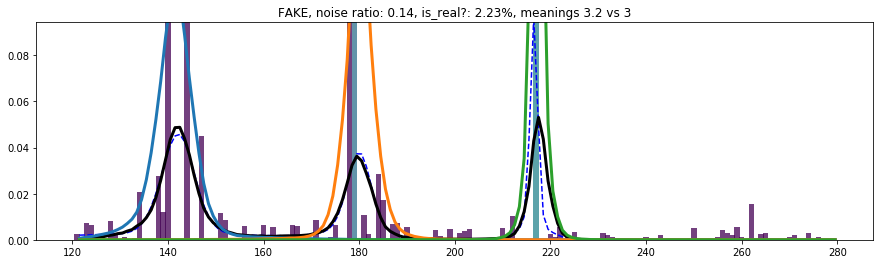

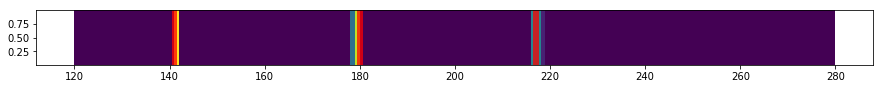

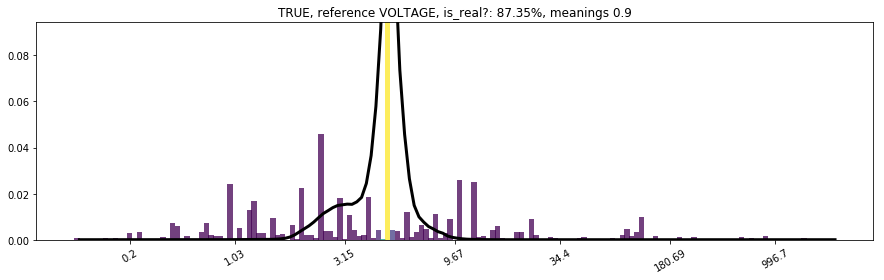

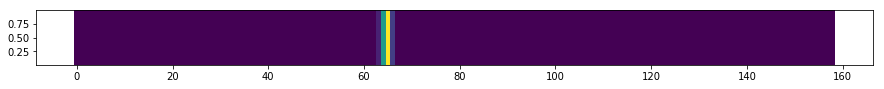

iter: 130, completed: 4.10%, smoother_loss: 1.0751, deconv_loss: 141.1711, smoother_reg: 0.0096, deconv_reg: 0.0182, peaks_loss: 0.8132, mn_loss: 0.1110, ro_pen: 0.0129
Smother | wts: (-14.56, 2.31)
Deconv | wts: (-4.74, 1.37)
error with  342 bins
error with  390 bins
iter: 135, completed: 4.26%, smoother_loss: 1.0740, deconv_loss: 134.3039, smoother_reg: 0.0094, deconv_reg: 0.0182, peaks_loss: 0.8118, mn_loss: 0.1114, ro_pen: 0.0128
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 140, completed: 4.41%, smoother_loss: 1.0712, deconv_loss: 127.7714, smoother_reg: 0.0093, deconv_reg: 0.0186, peaks_loss: 0.8091, mn_loss: 0.1101, ro_pen: 0.0126
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 145, completed: 4.57%, smoother_loss: 1.0768, deconv_loss: 121.5675, smoother_reg: 0.0093, deconv_reg: 0.0184, peaks_loss: 0.8153, mn_loss: 0.1102, ro_pen: 0.0124
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 150, completed: 4.72%, smoother_loss: 1.0804

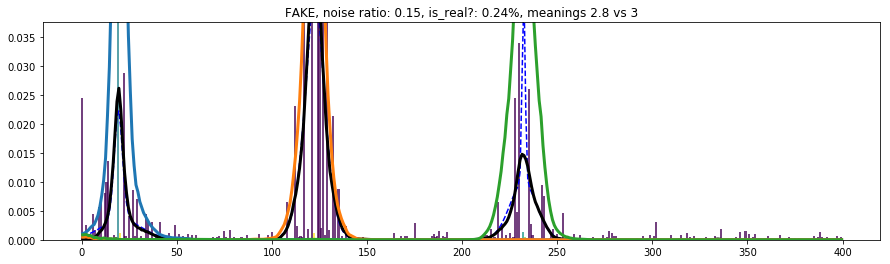

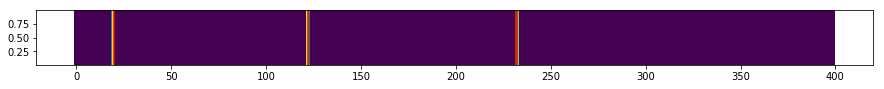

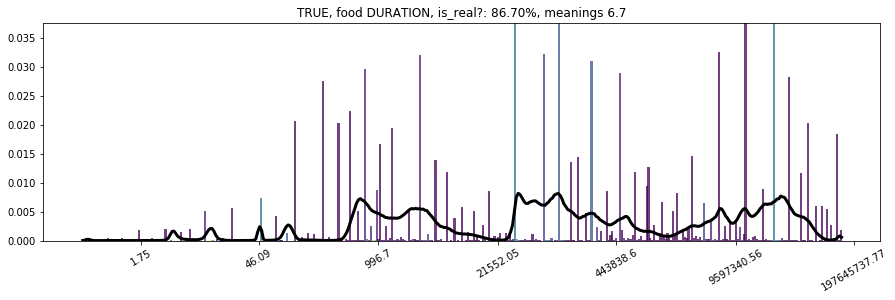

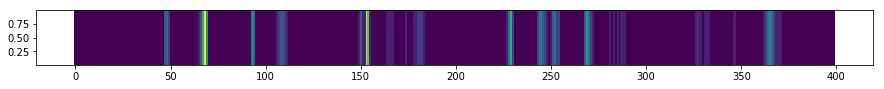

iter: 155, completed: 4.88%, smoother_loss: 1.0783, deconv_loss: 110.0479, smoother_reg: 0.0095, deconv_reg: 0.0185, peaks_loss: 0.8142, mn_loss: 0.1111, ro_pen: 0.0126
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
error with  323 bins
iter: 160, completed: 5.04%, smoother_loss: 1.0788, deconv_loss: 104.7079, smoother_reg: 0.0094, deconv_reg: 0.0187, peaks_loss: 0.8137, mn_loss: 0.1108, ro_pen: 0.0126
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 165, completed: 5.19%, smoother_loss: 1.0772, deconv_loss: 99.6274, smoother_reg: 0.0096, deconv_reg: 0.0186, peaks_loss: 0.8132, mn_loss: 0.1098, ro_pen: 0.0125
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 170, completed: 5.35%, smoother_loss: 1.0878, deconv_loss: 94.8081, smoother_reg: 0.0096, deconv_reg: 0.0187, peaks_loss: 0.8172, mn_loss: 0.1140, ro_pen: 0.0132
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 175, completed: 5.51%, smoother_loss: 1.0847, deconv_loss: 90.2117,

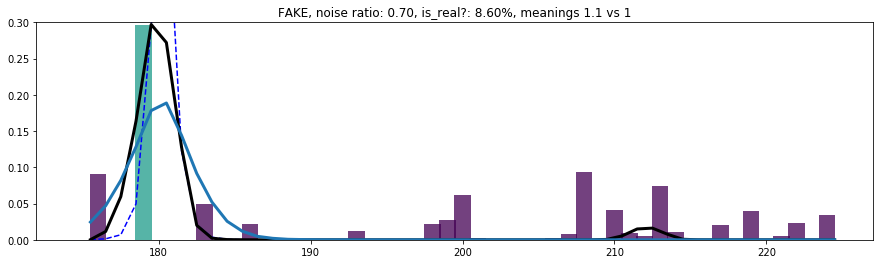

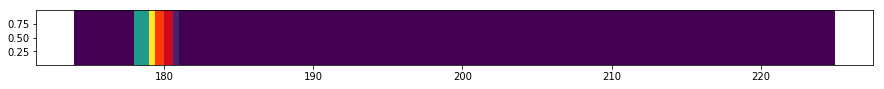

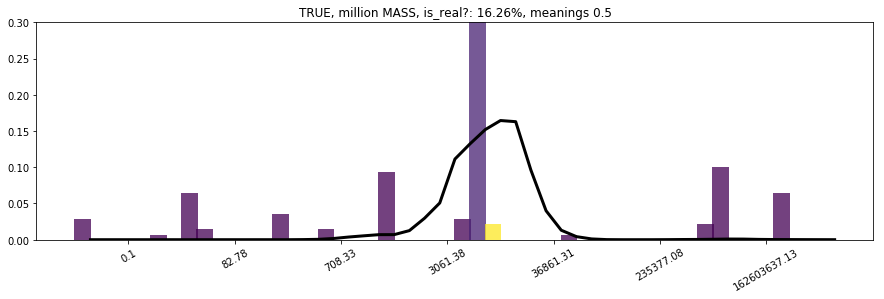

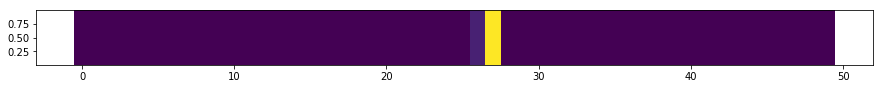

iter: 180, completed: 5.66%, smoother_loss: 1.0885, deconv_loss: 85.8474, smoother_reg: 0.0096, deconv_reg: 0.0188, peaks_loss: 0.8159, mn_loss: 0.1162, ro_pen: 0.0129
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 185, completed: 5.82%, smoother_loss: 1.0895, deconv_loss: 81.6944, smoother_reg: 0.0095, deconv_reg: 0.0187, peaks_loss: 0.8173, mn_loss: 0.1170, ro_pen: 0.0128
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 190, completed: 5.98%, smoother_loss: 1.0941, deconv_loss: 77.7485, smoother_reg: 0.0093, deconv_reg: 0.0186, peaks_loss: 0.8213, mn_loss: 0.1177, ro_pen: 0.0126
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 195, completed: 6.13%, smoother_loss: 1.0951, deconv_loss: 73.9927, smoother_reg: 0.0091, deconv_reg: 0.0186, peaks_loss: 0.8214, mn_loss: 0.1171, ro_pen: 0.0124
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 200, completed: 6.29%, smoother_loss: 1.0928, deconv_loss: 70.4177, smoother_reg: 0.0093, 

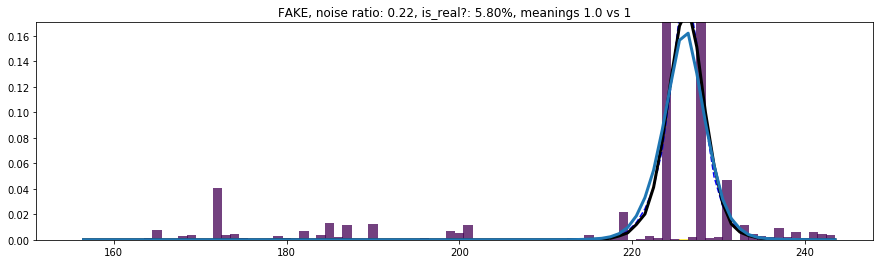

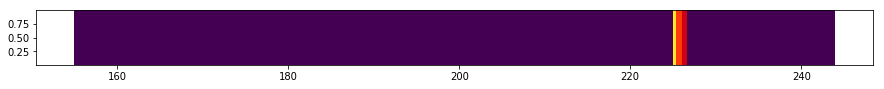

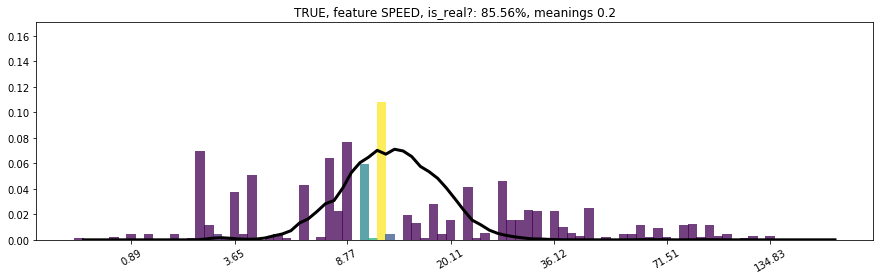

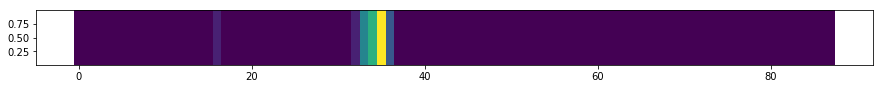

 smoother grad : Tensor had NaN values
	 [[node CheckNumerics_144 (defined at C:\Users\garci\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_train_step_175144]

Function call stack:
train_step

file  ../SmoothDoQ/doq_noun_batches/002532.json
iter: 205, completed: 6.45%, smoother_loss: 1.0876, deconv_loss: 67.0149, smoother_reg: 0.0093, deconv_reg: 0.0183, peaks_loss: 0.8171, mn_loss: 0.1143, ro_pen: 0.0123
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 210, completed: 6.60%, smoother_loss: 1.1027, deconv_loss: 63.7989, smoother_reg: 0.0093, deconv_reg: 0.0185, peaks_loss: 0.8196, mn_loss: 0.1225, ro_pen: 0.0150
Smother | wts: (-14.55, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 215, completed: 6.76%, smoother_loss: 1.1328, deconv_loss: 60.7563, smoother_reg: 0.0091, deconv_reg: 0.0184, peaks_loss: 0.8319, mn_loss: 0.1390, ro_pen: 0.0150
Smother | wts: (-14.54, 2.31)
Deconv | wts: (-4.74, 1.37)
iter: 220, completed: 6.91%, smooth

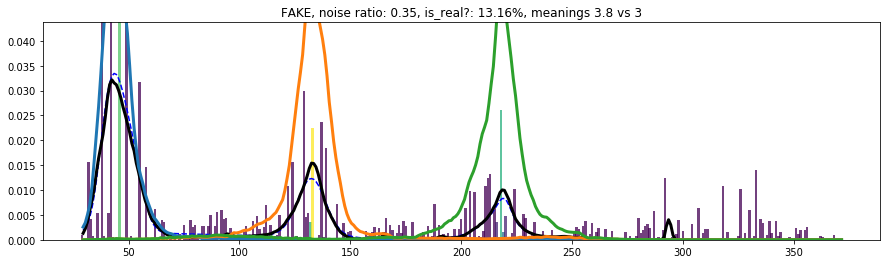

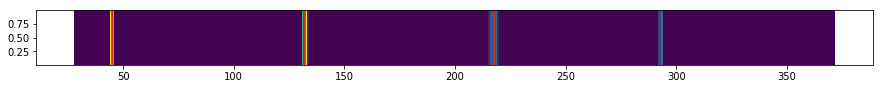

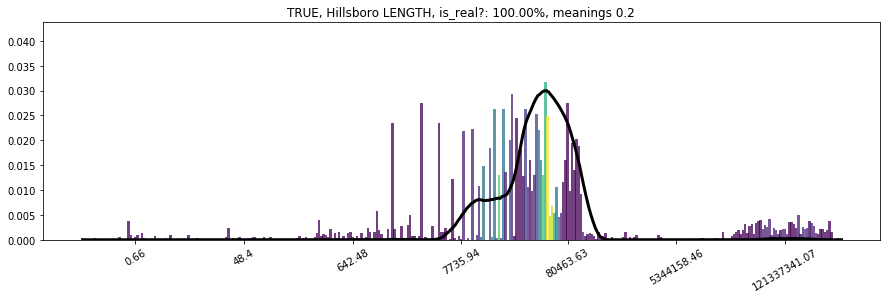

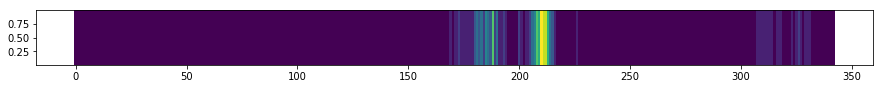

error with  306 bins
iter: 230, completed: 7.23%, smoother_loss: 1.1530, deconv_loss: 52.4327, smoother_reg: 0.0099, deconv_reg: 0.0185, peaks_loss: 0.8381, mn_loss: 0.1466, ro_pen: 0.0157
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
error with  266 bins
iter: 235, completed: 7.38%, smoother_loss: 1.1567, deconv_loss: 49.9231, smoother_reg: 0.0117, deconv_reg: 0.0187, peaks_loss: 0.8384, mn_loss: 0.1461, ro_pen: 0.0156
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 240, completed: 7.54%, smoother_loss: 1.1601, deconv_loss: 47.5365, smoother_reg: 0.0130, deconv_reg: 0.0187, peaks_loss: 0.8394, mn_loss: 0.1455, ro_pen: 0.0159
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 245, completed: 7.70%, smoother_loss: 1.1622, deconv_loss: 45.2657, smoother_reg: 0.0143, deconv_reg: 0.0188, peaks_loss: 0.8412, mn_loss: 0.1443, ro_pen: 0.0159
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 250, completed: 7.85%, smoother_loss: 1.1648, de

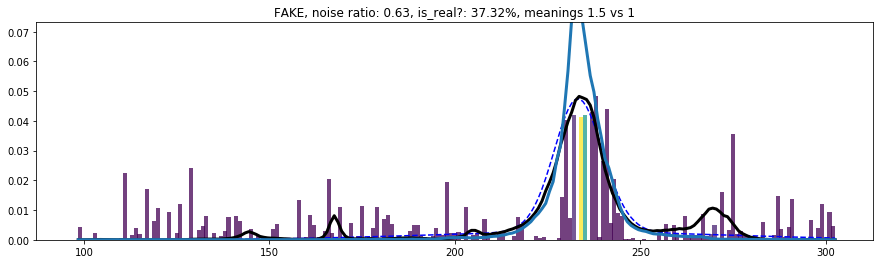

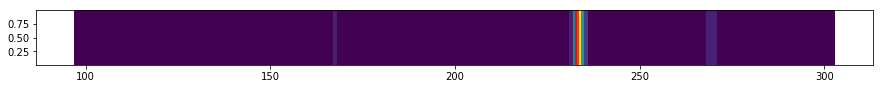

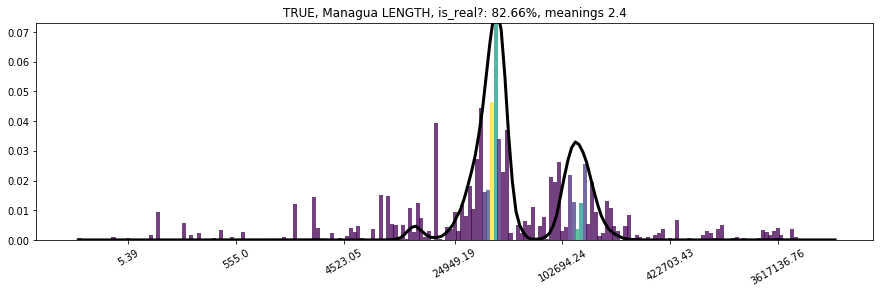

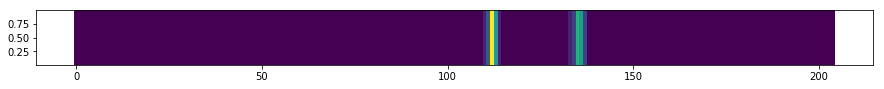

error with  276 bins
iter: 255, completed: 8.01%, smoother_loss: 1.1618, deconv_loss: 41.0482, smoother_reg: 0.0152, deconv_reg: 0.0185, peaks_loss: 0.8425, mn_loss: 0.1419, ro_pen: 0.0155
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
error with  238 bins
iter: 260, completed: 8.17%, smoother_loss: 1.1588, deconv_loss: 39.0904, smoother_reg: 0.0154, deconv_reg: 0.0186, peaks_loss: 0.8404, mn_loss: 0.1399, ro_pen: 0.0152
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 265, completed: 8.32%, smoother_loss: 1.1592, deconv_loss: 37.2317, smoother_reg: 0.0154, deconv_reg: 0.0186, peaks_loss: 0.8417, mn_loss: 0.1390, ro_pen: 0.0148
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
error with  414 bins
iter: 270, completed: 8.48%, smoother_loss: 1.1549, deconv_loss: 35.4596, smoother_reg: 0.0151, deconv_reg: 0.0187, peaks_loss: 0.8381, mn_loss: 0.1386, ro_pen: 0.0146
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 275, completed: 8.64%, smoo

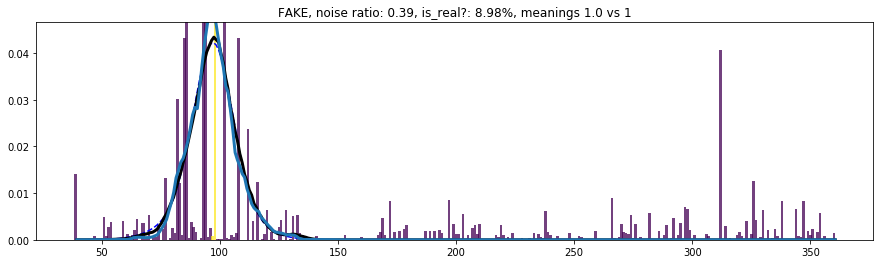

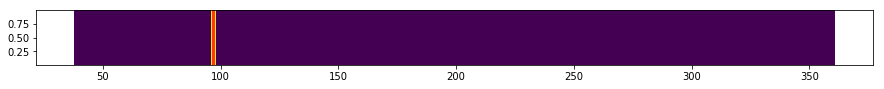

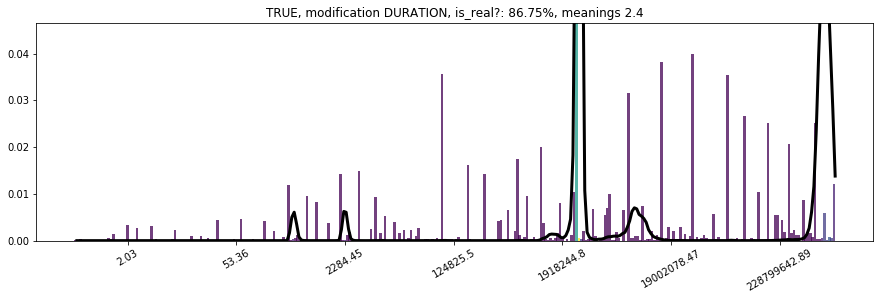

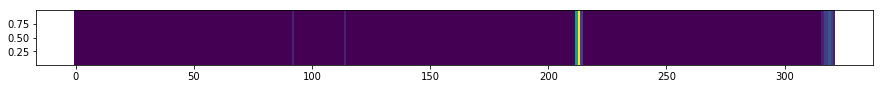

error with  420 bins
iter: 280, completed: 8.79%, smoother_loss: 1.1506, deconv_loss: 32.1751, smoother_reg: 0.0145, deconv_reg: 0.0187, peaks_loss: 0.8374, mn_loss: 0.1363, ro_pen: 0.0141
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 285, completed: 8.95%, smoother_loss: 1.1482, deconv_loss: 30.6522, smoother_reg: 0.0144, deconv_reg: 0.0187, peaks_loss: 0.8378, mn_loss: 0.1347, ro_pen: 0.0140
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
error with  324 bins
error with  210 bins
iter: 290, completed: 9.11%, smoother_loss: 1.1461, deconv_loss: 29.2041, smoother_reg: 0.0141, deconv_reg: 0.0186, peaks_loss: 0.8393, mn_loss: 0.1317, ro_pen: 0.0138
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
error with  403 bins
iter: 295, completed: 9.26%, smoother_loss: 1.1534, deconv_loss: 27.8363, smoother_reg: 0.0137, deconv_reg: 0.0185, peaks_loss: 0.8435, mn_loss: 0.1340, ro_pen: 0.0148
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 300, c

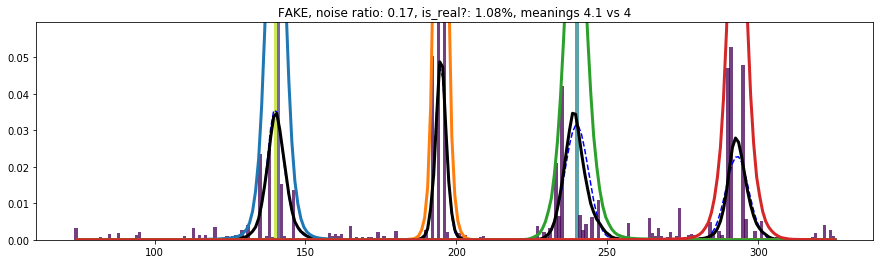

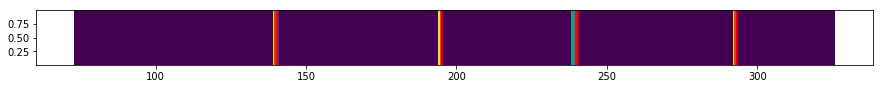

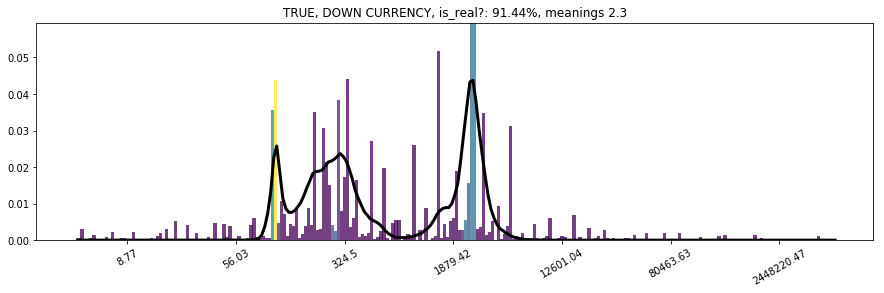

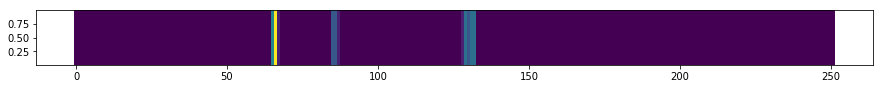

iter: 305, completed: 9.57%, smoother_loss: 1.1640, deconv_loss: 25.2955, smoother_reg: 0.0131, deconv_reg: 0.0184, peaks_loss: 0.8503, mn_loss: 0.1379, ro_pen: 0.0146
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 310, completed: 9.73%, smoother_loss: 1.1633, deconv_loss: 24.1121, smoother_reg: 0.0129, deconv_reg: 0.0185, peaks_loss: 0.8501, mn_loss: 0.1384, ro_pen: 0.0144
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.75, 1.37)
error with  362 bins
iter: 315, completed: 9.89%, smoother_loss: 1.1606, deconv_loss: 22.9847, smoother_reg: 0.0130, deconv_reg: 0.0186, peaks_loss: 0.8490, mn_loss: 0.1360, ro_pen: 0.0151
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 320, completed: 10.04%, smoother_loss: 1.1628, deconv_loss: 21.9173, smoother_reg: 0.0129, deconv_reg: 0.0185, peaks_loss: 0.8528, mn_loss: 0.1345, ro_pen: 0.0149
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
error with  313 bins
iter: 325, completed: 10.20%, smoother_loss: 1.1607, 

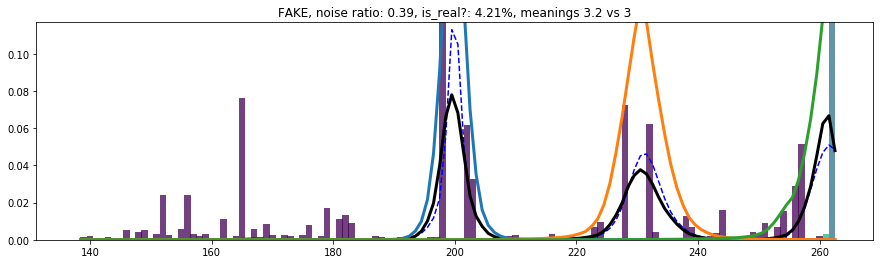

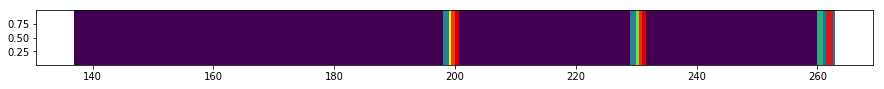

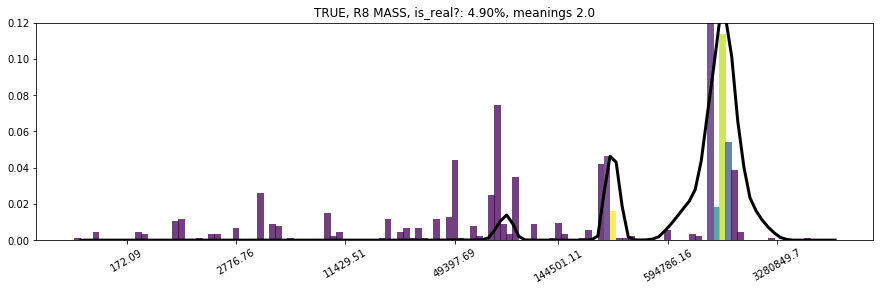

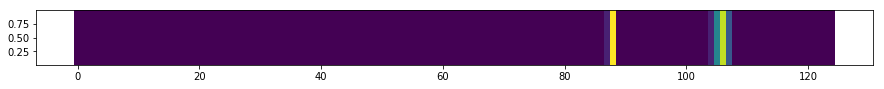

iter: 330, completed: 10.36%, smoother_loss: 1.1573, deconv_loss: 19.9273, smoother_reg: 0.0125, deconv_reg: 0.0184, peaks_loss: 0.8485, mn_loss: 0.1322, ro_pen: 0.0146
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 335, completed: 10.51%, smoother_loss: 1.1563, deconv_loss: 19.0064, smoother_reg: 0.0124, deconv_reg: 0.0184, peaks_loss: 0.8477, mn_loss: 0.1317, ro_pen: 0.0144
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.38)
error with  470 bins
iter: 340, completed: 10.67%, smoother_loss: 1.1559, deconv_loss: 18.1312, smoother_reg: 0.0121, deconv_reg: 0.0185, peaks_loss: 0.8474, mn_loss: 0.1318, ro_pen: 0.0143
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.38)
iter: 345, completed: 10.83%, smoother_loss: 1.1562, deconv_loss: 17.2995, smoother_reg: 0.0119, deconv_reg: 0.0185, peaks_loss: 0.8495, mn_loss: 0.1307, ro_pen: 0.0140
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.38)
iter: 350, completed: 10.98%, smoother_loss: 1.1516, deconv_loss: 16.50

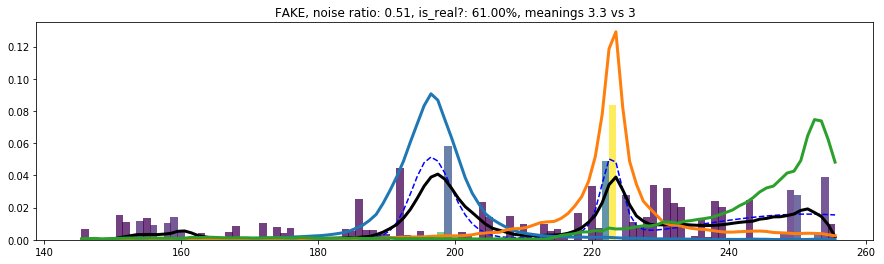

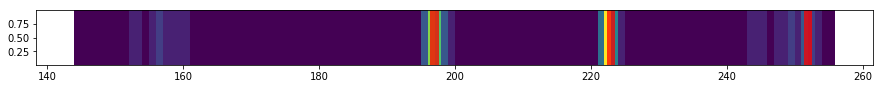

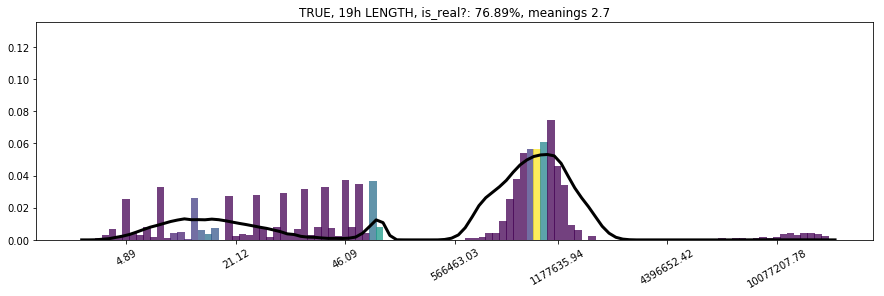

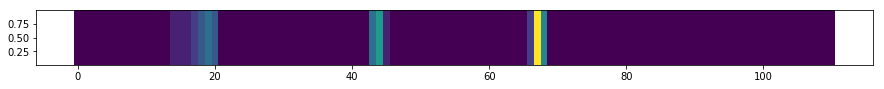

iter: 355, completed: 11.14%, smoother_loss: 1.1415, deconv_loss: 15.7412, smoother_reg: 0.0116, deconv_reg: 0.0184, peaks_loss: 0.8430, mn_loss: 0.1252, ro_pen: 0.0135
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.38)
iter: 360, completed: 11.30%, smoother_loss: 1.1344, deconv_loss: 15.0186, smoother_reg: 0.0114, deconv_reg: 0.0184, peaks_loss: 0.8396, mn_loss: 0.1230, ro_pen: 0.0133
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.38)
error with  334 bins
iter: 365, completed: 11.45%, smoother_loss: 1.1329, deconv_loss: 14.3366, smoother_reg: 0.0111, deconv_reg: 0.0182, peaks_loss: 0.8403, mn_loss: 0.1217, ro_pen: 0.0134
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.38)
error with  253 bins
iter: 370, completed: 11.61%, smoother_loss: 1.1334, deconv_loss: 13.6900, smoother_reg: 0.0111, deconv_reg: 0.0183, peaks_loss: 0.8407, mn_loss: 0.1221, ro_pen: 0.0132
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.38)
error with  433 bins
 smoother grad : Tensor had N

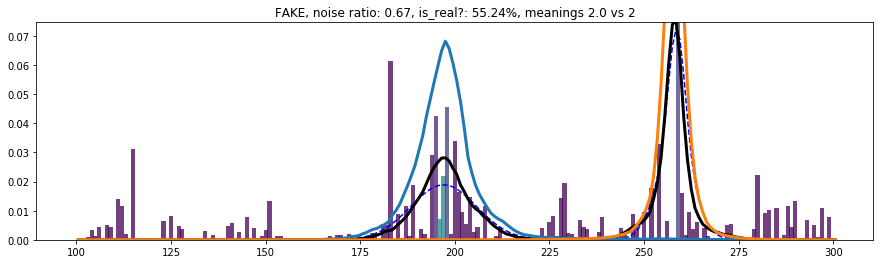

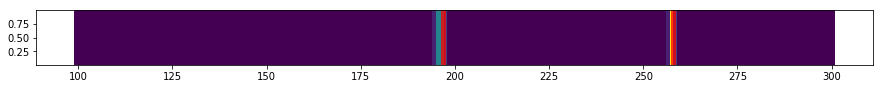

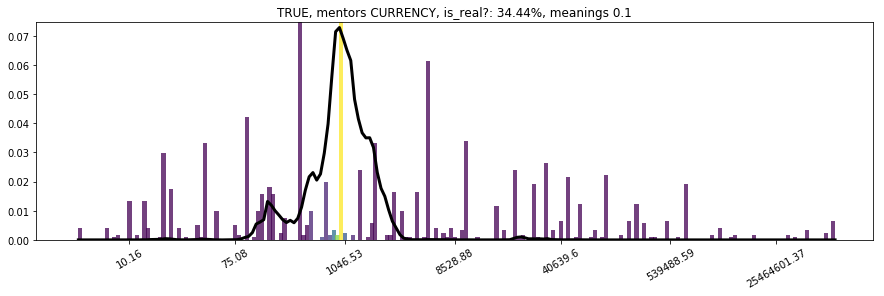

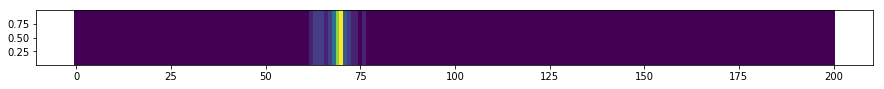

iter: 380, completed: 11.92%, smoother_loss: 1.1304, deconv_loss: 12.4864, smoother_reg: 0.0108, deconv_reg: 0.0182, peaks_loss: 0.8384, mn_loss: 0.1207, ro_pen: 0.0131
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.75, 1.38)


C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


iter: 385, completed: 12.08%, smoother_loss: 1.1303, deconv_loss: 11.9297, smoother_reg: 0.0109, deconv_reg: 0.0183, peaks_loss: 0.8368, mn_loss: 0.1205, ro_pen: 0.0131
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.75, 1.37)
error with  251 bins
iter: 390, completed: 12.23%, smoother_loss: 1.1286, deconv_loss: 11.3987, smoother_reg: 0.0107, deconv_reg: 0.0183, peaks_loss: 0.8372, mn_loss: 0.1189, ro_pen: 0.0129
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.74, 1.37)
iter: 395, completed: 12.39%, smoother_loss: 1.1274, deconv_loss: 10.8942, smoother_reg: 0.0105, deconv_reg: 0.0184, peaks_loss: 0.8349, mn_loss: 0.1191, ro_pen: 0.0128
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.75, 1.37)
iter: 400, completed: 12.55%, smoother_loss: 1.1251, deconv_loss: 10.4132, smoother_reg: 0.0103, deconv_reg: 0.0183, peaks_loss: 0.8331, mn_loss: 0.1185, ro_pen: 0.0128
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.75, 1.37)


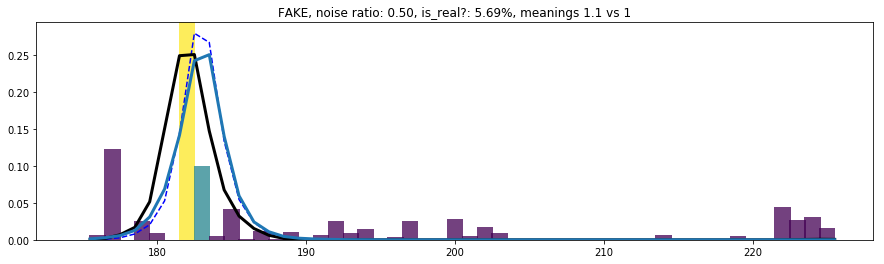

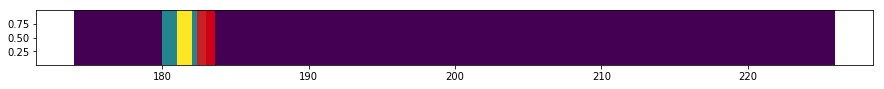

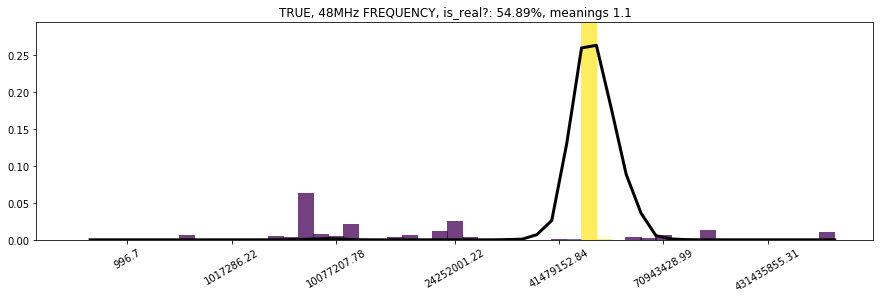

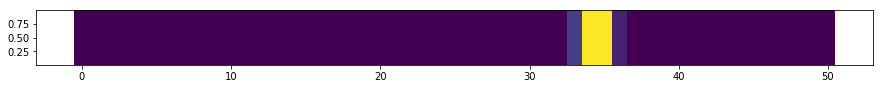

iter: 405, completed: 12.70%, smoother_loss: 1.1276, deconv_loss: 9.9605, smoother_reg: 0.0102, deconv_reg: 0.0182, peaks_loss: 0.8374, mn_loss: 0.1178, ro_pen: 0.0128
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 410, completed: 12.86%, smoother_loss: 1.1273, deconv_loss: 9.5273, smoother_reg: 0.0100, deconv_reg: 0.0182, peaks_loss: 0.8376, mn_loss: 0.1175, ro_pen: 0.0126
Smother | wts: (-14.54, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 415, completed: 13.02%, smoother_loss: 1.1262, deconv_loss: 9.1145, smoother_reg: 0.0100, deconv_reg: 0.0181, peaks_loss: 0.8357, mn_loss: 0.1190, ro_pen: 0.0125
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 420, completed: 13.17%, smoother_loss: 1.1269, deconv_loss: 8.7237, smoother_reg: 0.0099, deconv_reg: 0.0182, peaks_loss: 0.8352, mn_loss: 0.1203, ro_pen: 0.0126
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 425, completed: 13.33%, smoother_loss: 1.1258, deconv_loss: 8.3503, smoother_reg: 0.0097, 

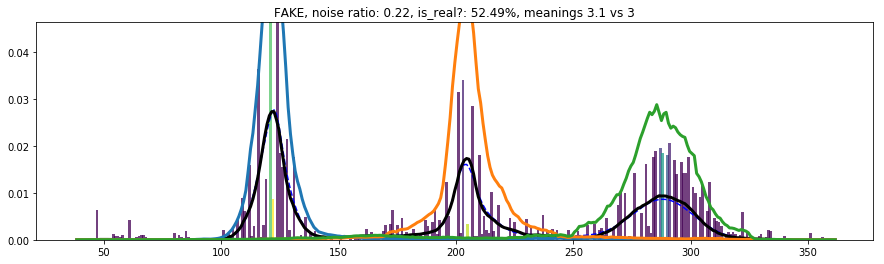

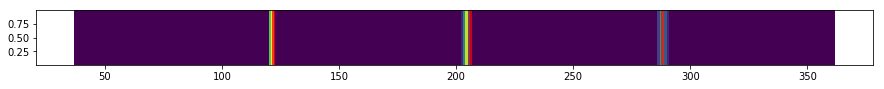

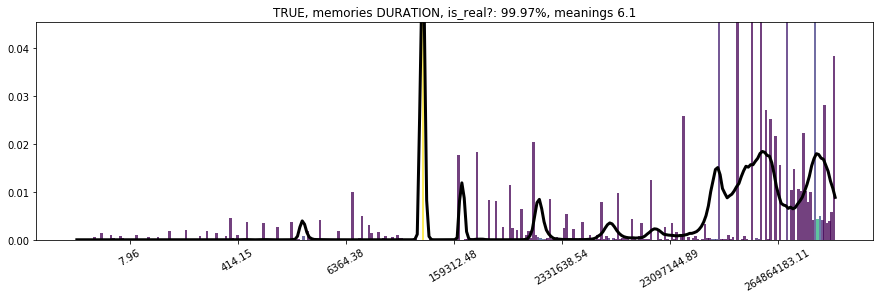

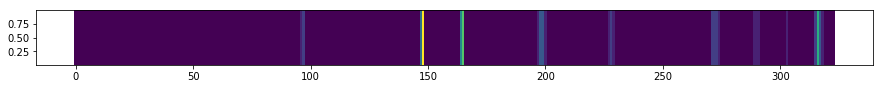

iter: 430, completed: 13.49%, smoother_loss: 1.1220, deconv_loss: 7.9924, smoother_reg: 0.0097, deconv_reg: 0.0182, peaks_loss: 0.8317, mn_loss: 0.1196, ro_pen: 0.0125
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 435, completed: 13.64%, smoother_loss: 1.1262, deconv_loss: 7.6599, smoother_reg: 0.0096, deconv_reg: 0.0182, peaks_loss: 0.8348, mn_loss: 0.1206, ro_pen: 0.0123
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 440, completed: 13.80%, smoother_loss: 1.1250, deconv_loss: 7.3385, smoother_reg: 0.0094, deconv_reg: 0.0182, peaks_loss: 0.8352, mn_loss: 0.1192, ro_pen: 0.0122
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
error with  383 bins
iter: 445, completed: 13.95%, smoother_loss: 1.1227, deconv_loss: 7.0317, smoother_reg: 0.0093, deconv_reg: 0.0184, peaks_loss: 0.8318, mn_loss: 0.1194, ro_pen: 0.0122
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 450, completed: 14.11%, smoother_loss: 1.1183, deconv_loss: 6.7377, s

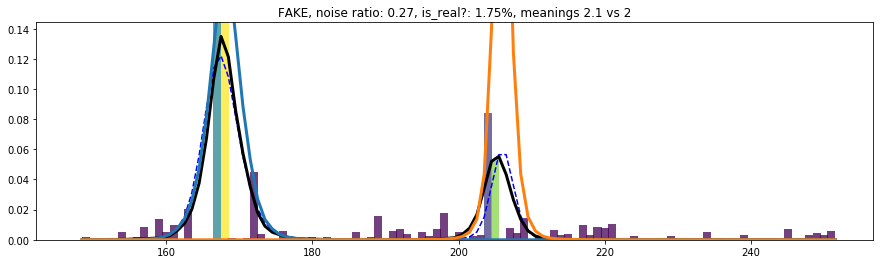

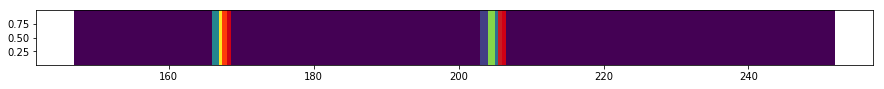

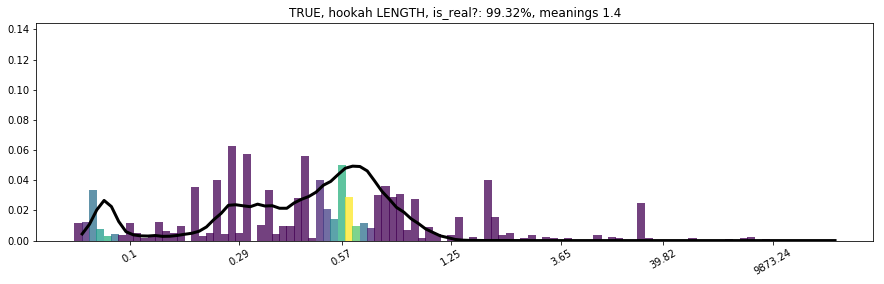

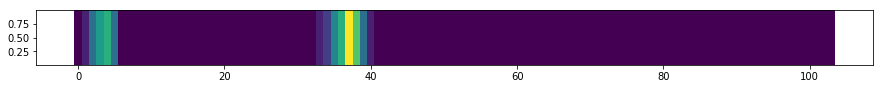

iter: 455, completed: 14.27%, smoother_loss: 1.1189, deconv_loss: 6.4628, smoother_reg: 0.0091, deconv_reg: 0.0186, peaks_loss: 0.8299, mn_loss: 0.1186, ro_pen: 0.0121
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 460, completed: 14.42%, smoother_loss: 1.1314, deconv_loss: 6.2134, smoother_reg: 0.0090, deconv_reg: 0.0184, peaks_loss: 0.8349, mn_loss: 0.1239, ro_pen: 0.0122
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 465, completed: 14.58%, smoother_loss: 1.1364, deconv_loss: 5.9694, smoother_reg: 0.0087, deconv_reg: 0.0184, peaks_loss: 0.8381, mn_loss: 0.1259, ro_pen: 0.0120
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 470, completed: 14.74%, smoother_loss: 1.1319, deconv_loss: 5.7280, smoother_reg: 0.0086, deconv_reg: 0.0186, peaks_loss: 0.8371, mn_loss: 0.1238, ro_pen: 0.0119
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
 smoother grad : Tensor had NaN values
	 [[node CheckNumerics_144 (defined at C:\Users\garci\Ana

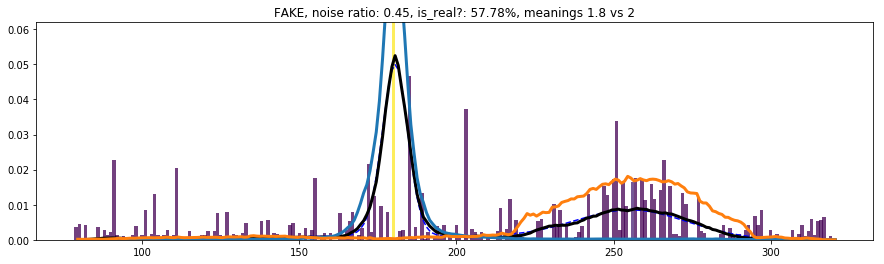

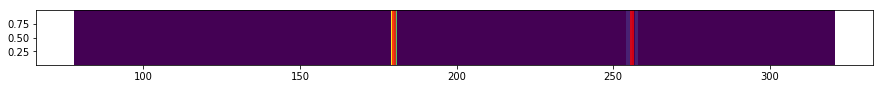

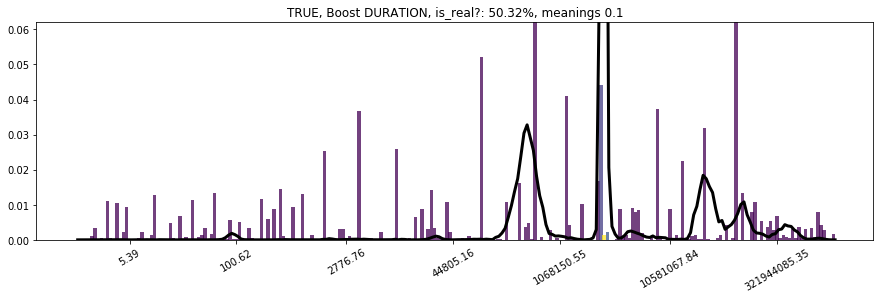

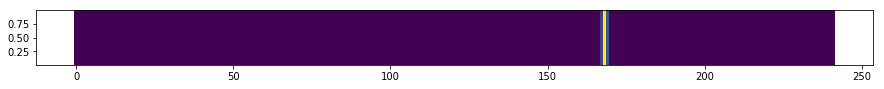

iter: 480, completed: 15.05%, smoother_loss: 1.1293, deconv_loss: 5.2859, smoother_reg: 0.0088, deconv_reg: 0.0184, peaks_loss: 0.8368, mn_loss: 0.1221, ro_pen: 0.0116
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 485, completed: 15.21%, smoother_loss: 1.1264, deconv_loss: 5.0794, smoother_reg: 0.0088, deconv_reg: 0.0184, peaks_loss: 0.8354, mn_loss: 0.1215, ro_pen: 0.0118
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 490, completed: 15.36%, smoother_loss: 1.1250, deconv_loss: 4.8842, smoother_reg: 0.0088, deconv_reg: 0.0185, peaks_loss: 0.8363, mn_loss: 0.1196, ro_pen: 0.0116
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 495, completed: 15.52%, smoother_loss: 1.1257, deconv_loss: 4.7006, smoother_reg: 0.0087, deconv_reg: 0.0183, peaks_loss: 0.8378, mn_loss: 0.1195, ro_pen: 0.0115
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
error with  467 bins
iter: 500, completed: 15.68%, smoother_loss: 1.1235, deconv_loss: 4.5233, s

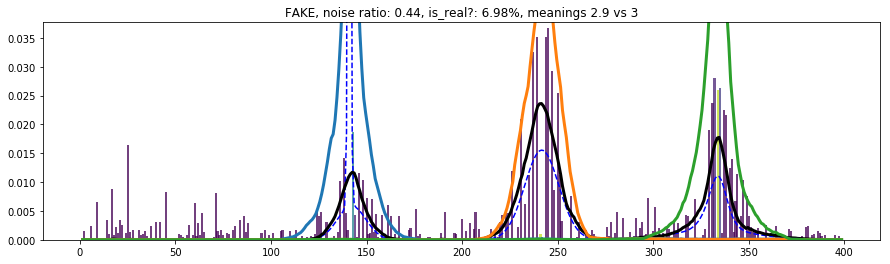

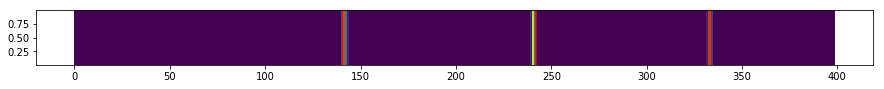

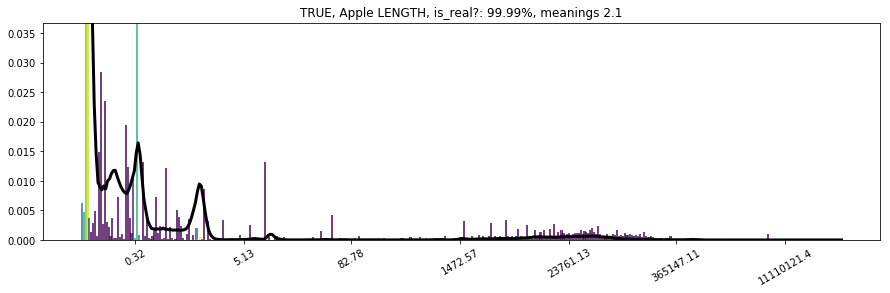

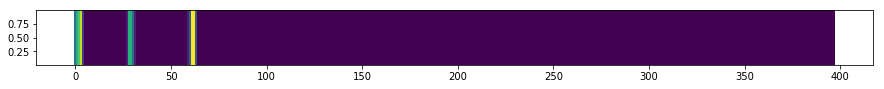

iter: 505, completed: 15.83%, smoother_loss: 1.1274, deconv_loss: 4.3606, smoother_reg: 0.0087, deconv_reg: 0.0183, peaks_loss: 0.8399, mn_loss: 0.1199, ro_pen: 0.0115
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 510, completed: 15.99%, smoother_loss: 1.1276, deconv_loss: 4.2023, smoother_reg: 0.0087, deconv_reg: 0.0185, peaks_loss: 0.8399, mn_loss: 0.1206, ro_pen: 0.0115
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 515, completed: 16.15%, smoother_loss: 1.1255, deconv_loss: 4.0495, smoother_reg: 0.0087, deconv_reg: 0.0185, peaks_loss: 0.8387, mn_loss: 0.1198, ro_pen: 0.0114
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
 smoother grad : Tensor had NaN values
	 [[node CheckNumerics_144 (defined at C:\Users\garci\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_train_step_1123259]

Function call stack:
train_step

file  ../SmoothDoQ/doq_noun_batches/000543.json
iter: 520, completed: 16.30%, smoo

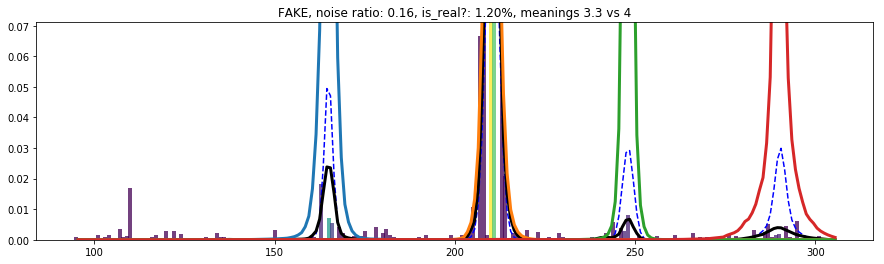

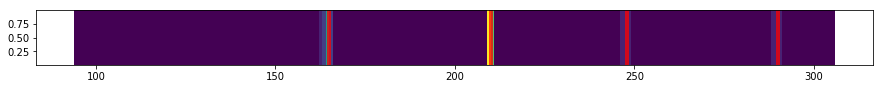

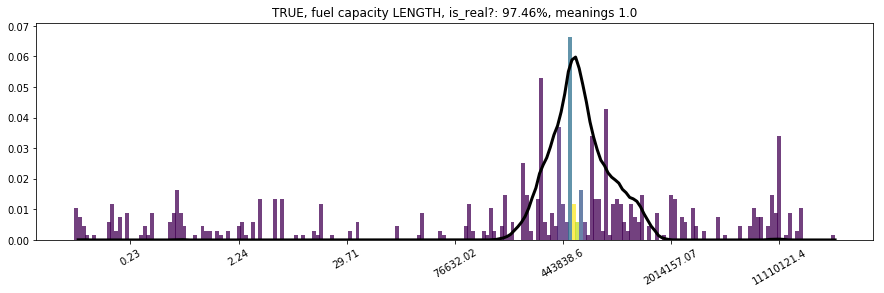

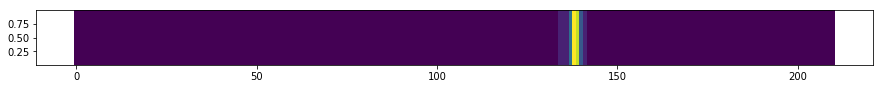

error with  295 bins
iter: 530, completed: 16.61%, smoother_loss: 1.1141, deconv_loss: 3.6289, smoother_reg: 0.0085, deconv_reg: 0.0185, peaks_loss: 0.8307, mn_loss: 0.1177, ro_pen: 0.0118
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
error with  381 bins
iter: 535, completed: 16.77%, smoother_loss: 1.1137, deconv_loss: 3.5053, smoother_reg: 0.0084, deconv_reg: 0.0186, peaks_loss: 0.8309, mn_loss: 0.1161, ro_pen: 0.0118
Smother | wts: (-14.53, 2.30)
Deconv | wts: (-4.75, 1.38)
iter: 540, completed: 16.93%, smoother_loss: 1.1209, deconv_loss: 3.3952, smoother_reg: 0.0084, deconv_reg: 0.0188, peaks_loss: 0.8333, mn_loss: 0.1167, ro_pen: 0.0127
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.38)
error with  428 bins
iter: 545, completed: 17.08%, smoother_loss: 1.1280, deconv_loss: 3.2908, smoother_reg: 0.0087, deconv_reg: 0.0188, peaks_loss: 0.8363, mn_loss: 0.1170, ro_pen: 0.0126
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.38)


C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


iter: 550, completed: 17.24%, smoother_loss: 1.1292, deconv_loss: 3.1861, smoother_reg: 0.0086, deconv_reg: 0.0187, peaks_loss: 0.8367, mn_loss: 0.1179, ro_pen: 0.0126
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.38)


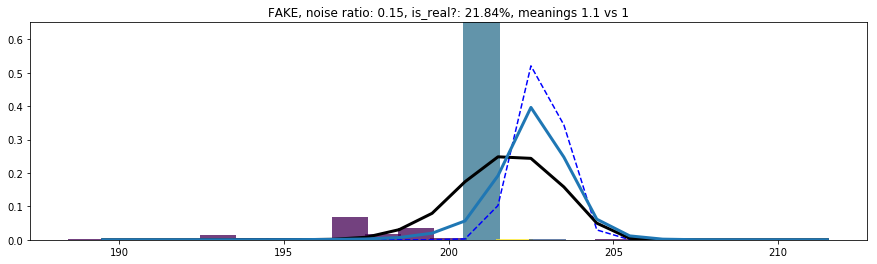

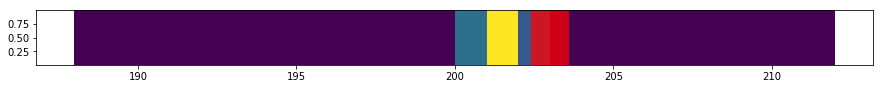

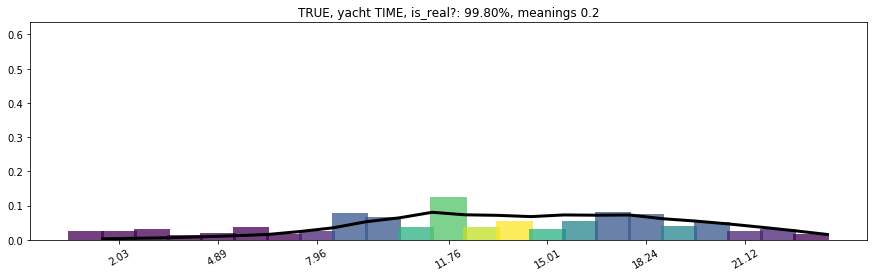

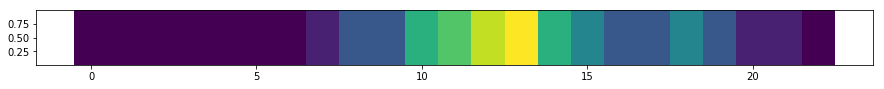

iter: 555, completed: 17.40%, smoother_loss: 1.1341, deconv_loss: 3.0902, smoother_reg: 0.0084, deconv_reg: 0.0191, peaks_loss: 0.8378, mn_loss: 0.1201, ro_pen: 0.0128
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.38)
iter: 560, completed: 17.55%, smoother_loss: 1.1381, deconv_loss: 2.9983, smoother_reg: 0.0083, deconv_reg: 0.0188, peaks_loss: 0.8428, mn_loss: 0.1200, ro_pen: 0.0128
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 565, completed: 17.71%, smoother_loss: 1.1358, deconv_loss: 2.9048, smoother_reg: 0.0083, deconv_reg: 0.0188, peaks_loss: 0.8411, mn_loss: 0.1193, ro_pen: 0.0128
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 570, completed: 17.87%, smoother_loss: 1.1352, deconv_loss: 2.8175, smoother_reg: 0.0084, deconv_reg: 0.0187, peaks_loss: 0.8408, mn_loss: 0.1184, ro_pen: 0.0129
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 575, completed: 18.02%, smoother_loss: 1.1346, deconv_loss: 2.7344, smoother_reg: 0.0084, 

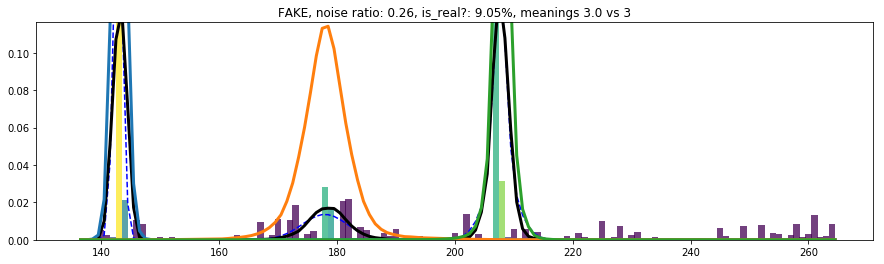

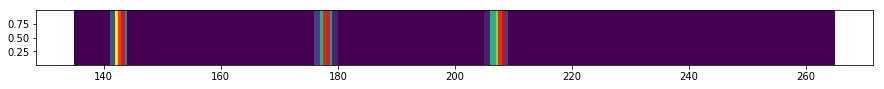

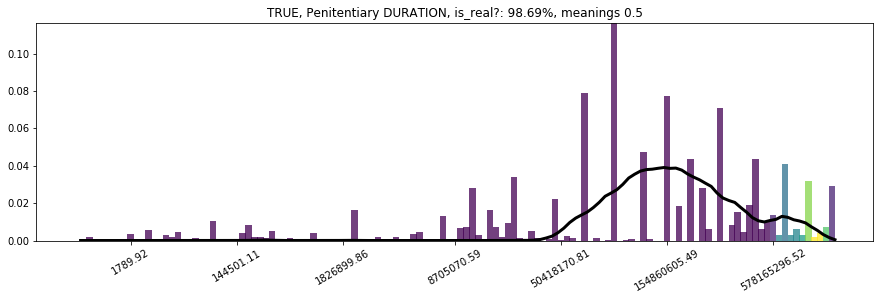

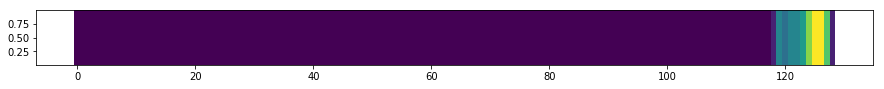

error with  261 bins
iter: 580, completed: 18.18%, smoother_loss: 1.1341, deconv_loss: 2.6556, smoother_reg: 0.0085, deconv_reg: 0.0189, peaks_loss: 0.8407, mn_loss: 0.1181, ro_pen: 0.0127
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.38)
error with  354 bins
iter: 585, completed: 18.34%, smoother_loss: 1.1339, deconv_loss: 2.5808, smoother_reg: 0.0085, deconv_reg: 0.0188, peaks_loss: 0.8430, mn_loss: 0.1169, ro_pen: 0.0126
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.38)
error with  327 bins
iter: 590, completed: 18.49%, smoother_loss: 1.1355, deconv_loss: 2.5115, smoother_reg: 0.0084, deconv_reg: 0.0189, peaks_loss: 0.8436, mn_loss: 0.1166, ro_pen: 0.0130
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.38)
iter: 595, completed: 18.65%, smoother_loss: 1.1431, deconv_loss: 2.4517, smoother_reg: 0.0083, deconv_reg: 0.0190, peaks_loss: 0.8446, mn_loss: 0.1195, ro_pen: 0.0139
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.38)
error with  457 bins
error with  

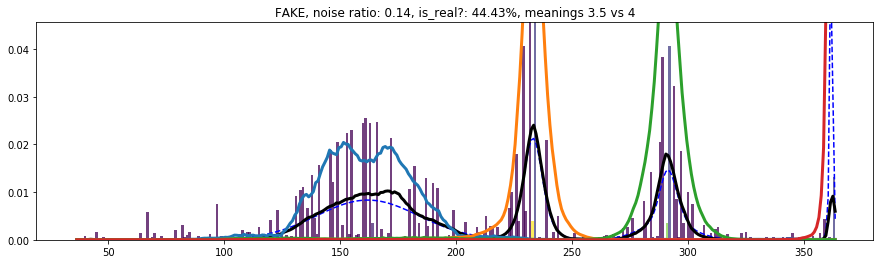

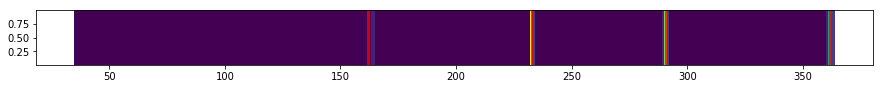

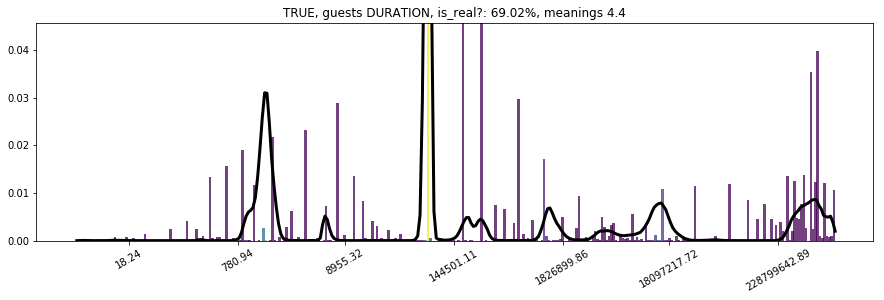

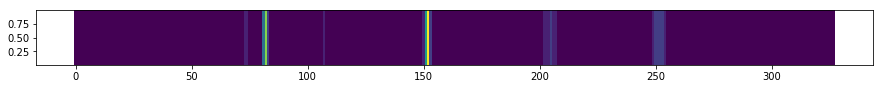

iter: 605, completed: 18.96%, smoother_loss: 1.1394, deconv_loss: 2.3228, smoother_reg: 0.0083, deconv_reg: 0.0188, peaks_loss: 0.8436, mn_loss: 0.1177, ro_pen: 0.0132
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.37)
iter: 610, completed: 19.12%, smoother_loss: 1.1420, deconv_loss: 2.2674, smoother_reg: 0.0083, deconv_reg: 0.0187, peaks_loss: 0.8451, mn_loss: 0.1184, ro_pen: 0.0132
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.37)
iter: 615, completed: 19.27%, smoother_loss: 1.1389, deconv_loss: 2.2092, smoother_reg: 0.0082, deconv_reg: 0.0189, peaks_loss: 0.8441, mn_loss: 0.1170, ro_pen: 0.0130
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.37)
error with  470 bins
iter: 620, completed: 19.43%, smoother_loss: 1.1426, deconv_loss: 2.1604, smoother_reg: 0.0082, deconv_reg: 0.0188, peaks_loss: 0.8474, mn_loss: 0.1167, ro_pen: 0.0130
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.75, 1.37)
iter: 625, completed: 19.59%, smoother_loss: 1.1368, deconv_loss: 2.1047, s

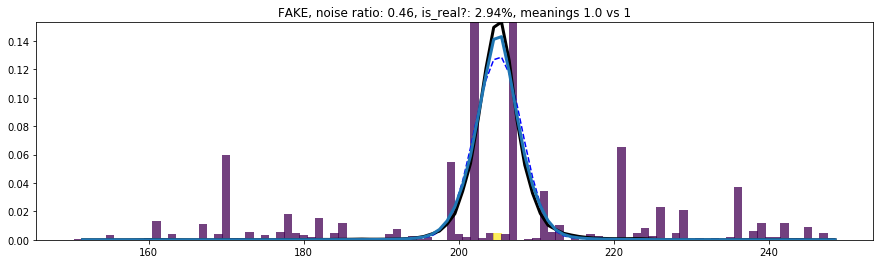

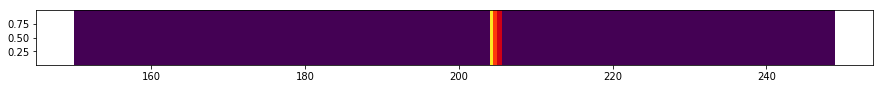

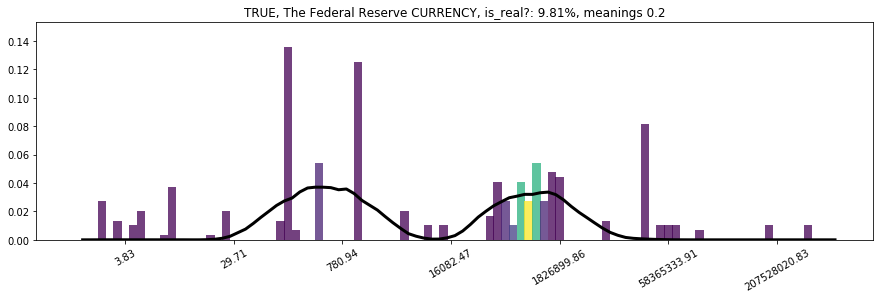

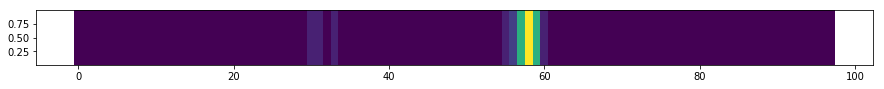

iter: 630, completed: 19.74%, smoother_loss: 1.1394, deconv_loss: 2.0599, smoother_reg: 0.0081, deconv_reg: 0.0188, peaks_loss: 0.8444, mn_loss: 0.1189, ro_pen: 0.0129
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 635, completed: 19.90%, smoother_loss: 1.1341, deconv_loss: 2.0095, smoother_reg: 0.0080, deconv_reg: 0.0187, peaks_loss: 0.8412, mn_loss: 0.1178, ro_pen: 0.0128
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 640, completed: 20.06%, smoother_loss: 1.1299, deconv_loss: 1.9624, smoother_reg: 0.0079, deconv_reg: 0.0187, peaks_loss: 0.8392, mn_loss: 0.1160, ro_pen: 0.0126
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 645, completed: 20.21%, smoother_loss: 1.1311, deconv_loss: 1.9228, smoother_reg: 0.0078, deconv_reg: 0.0186, peaks_loss: 0.8419, mn_loss: 0.1166, ro_pen: 0.0125
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 650, completed: 20.37%, smoother_loss: 1.1301, deconv_loss: 1.8830, smoother_reg: 0.0081, 

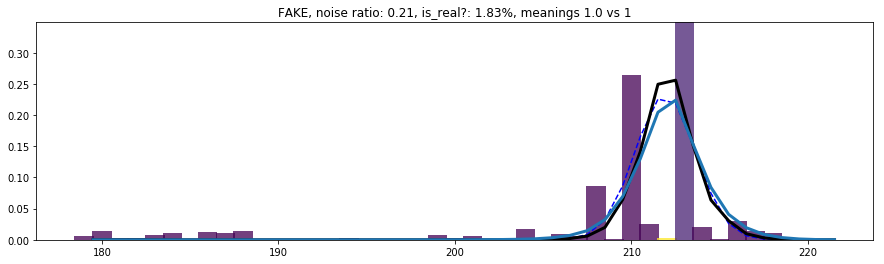

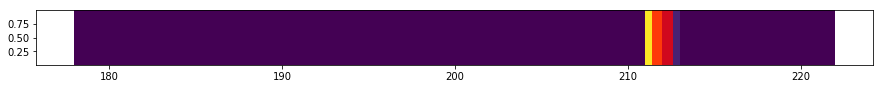

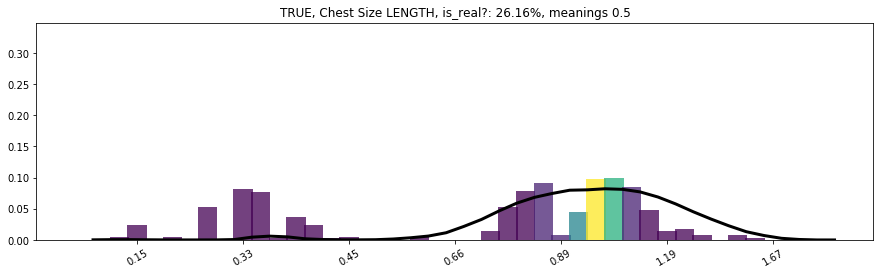

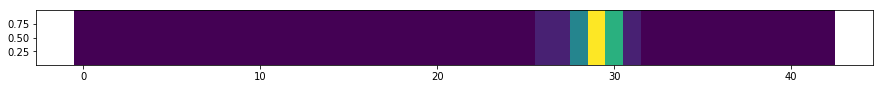

iter: 655, completed: 20.53%, smoother_loss: 1.1295, deconv_loss: 1.8454, smoother_reg: 0.0079, deconv_reg: 0.0187, peaks_loss: 0.8422, mn_loss: 0.1164, ro_pen: 0.0123
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.37)
iter: 660, completed: 20.68%, smoother_loss: 1.1279, deconv_loss: 1.8088, smoother_reg: 0.0077, deconv_reg: 0.0184, peaks_loss: 0.8424, mn_loss: 0.1153, ro_pen: 0.0123
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 665, completed: 20.84%, smoother_loss: 1.1264, deconv_loss: 1.7739, smoother_reg: 0.0077, deconv_reg: 0.0186, peaks_loss: 0.8432, mn_loss: 0.1138, ro_pen: 0.0120
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 670, completed: 20.99%, smoother_loss: 1.1227, deconv_loss: 1.7385, smoother_reg: 0.0079, deconv_reg: 0.0187, peaks_loss: 0.8397, mn_loss: 0.1138, ro_pen: 0.0120
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 675, completed: 21.15%, smoother_loss: 1.1239, deconv_loss: 1.7095, smoother_reg: 0.0079, 

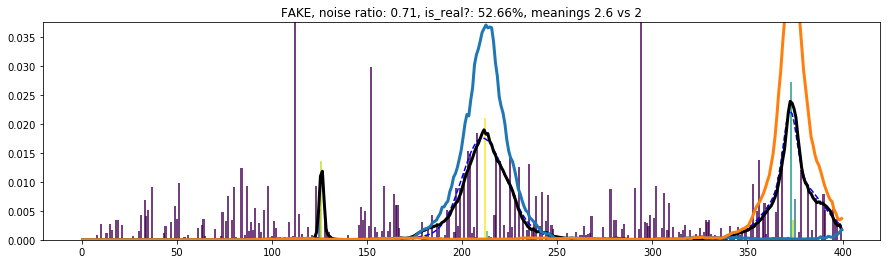

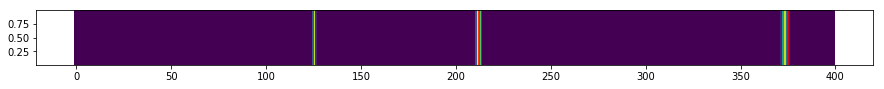

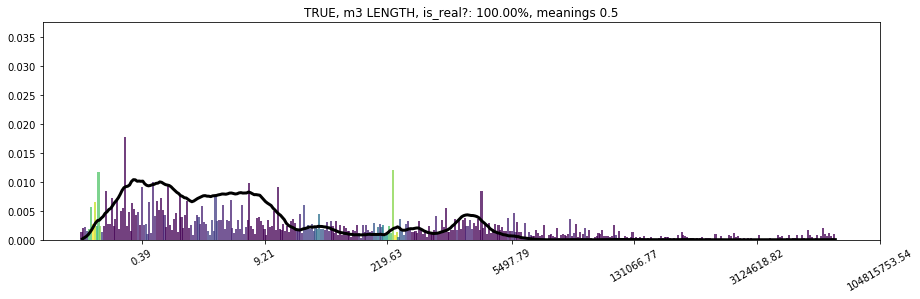

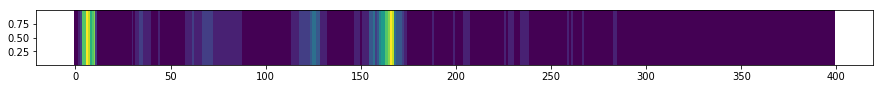

error with  414 bins
iter: 680, completed: 21.31%, smoother_loss: 1.1307, deconv_loss: 1.6876, smoother_reg: 0.0080, deconv_reg: 0.0190, peaks_loss: 0.8428, mn_loss: 0.1174, ro_pen: 0.0121
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  341 bins
iter: 685, completed: 21.46%, smoother_loss: 1.1315, deconv_loss: 1.6611, smoother_reg: 0.0079, deconv_reg: 0.0189, peaks_loss: 0.8411, mn_loss: 0.1186, ro_pen: 0.0121
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 690, completed: 21.62%, smoother_loss: 1.1319, deconv_loss: 1.6355, smoother_reg: 0.0079, deconv_reg: 0.0189, peaks_loss: 0.8398, mn_loss: 0.1194, ro_pen: 0.0122
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  214 bins
iter: 695, completed: 21.78%, smoother_loss: 1.1332, deconv_loss: 1.6122, smoother_reg: 0.0082, deconv_reg: 0.0189, peaks_loss: 0.8405, mn_loss: 0.1190, ro_pen: 0.0121
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 700, completed: 21.93%, smo

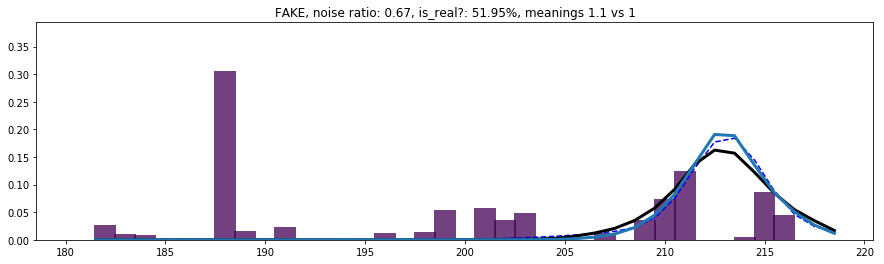

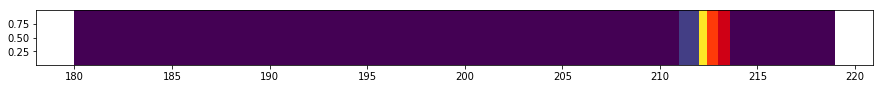

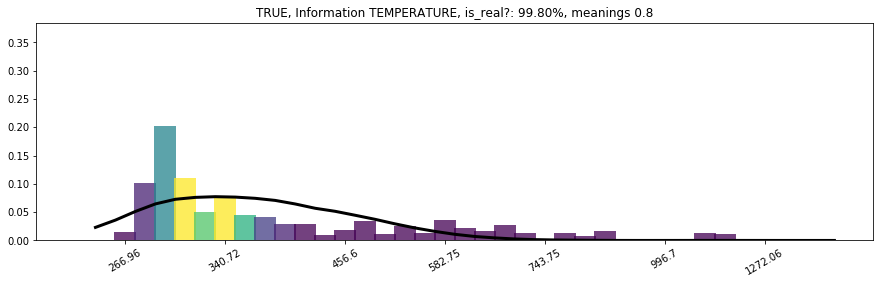

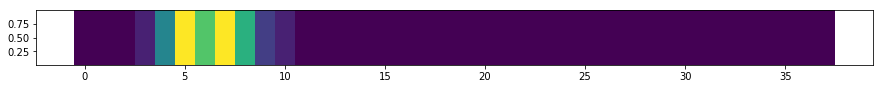

error with  400 bins
iter: 705, completed: 22.09%, smoother_loss: 1.1403, deconv_loss: 1.5734, smoother_reg: 0.0085, deconv_reg: 0.0187, peaks_loss: 0.8455, mn_loss: 0.1202, ro_pen: 0.0121
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 710, completed: 22.25%, smoother_loss: 1.1390, deconv_loss: 1.5509, smoother_reg: 0.0085, deconv_reg: 0.0188, peaks_loss: 0.8447, mn_loss: 0.1217, ro_pen: 0.0120
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 715, completed: 22.40%, smoother_loss: 1.1360, deconv_loss: 1.5277, smoother_reg: 0.0083, deconv_reg: 0.0187, peaks_loss: 0.8430, mn_loss: 0.1215, ro_pen: 0.0118
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 720, completed: 22.56%, smoother_loss: 1.1350, deconv_loss: 1.5076, smoother_reg: 0.0083, deconv_reg: 0.0187, peaks_loss: 0.8446, mn_loss: 0.1204, ro_pen: 0.0117
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  398 bins
iter: 725, completed: 22.72%, smoother_loss: 1.1307, d

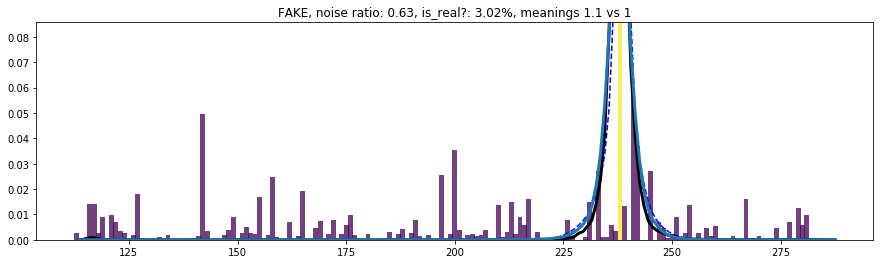

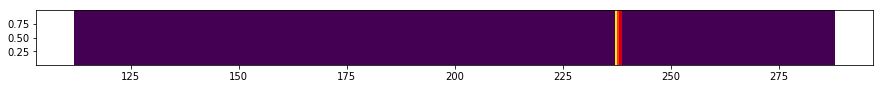

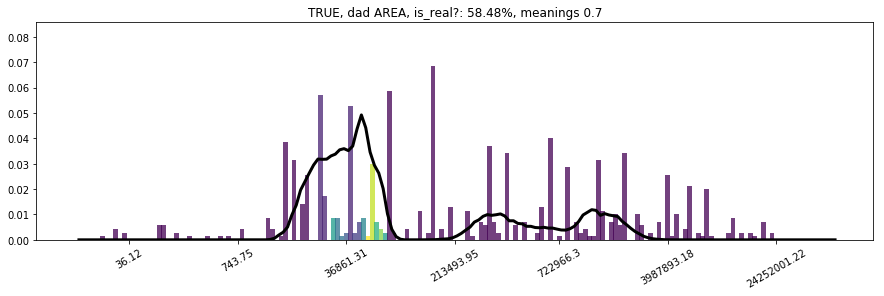

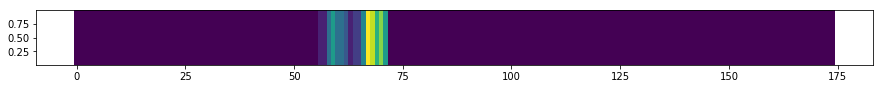

iter: 730, completed: 22.87%, smoother_loss: 1.1217, deconv_loss: 1.4586, smoother_reg: 0.0084, deconv_reg: 0.0188, peaks_loss: 0.8353, mn_loss: 0.1162, ro_pen: 0.0115
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 735, completed: 23.03%, smoother_loss: 1.1207, deconv_loss: 1.4411, smoother_reg: 0.0084, deconv_reg: 0.0191, peaks_loss: 0.8331, mn_loss: 0.1159, ro_pen: 0.0116
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 740, completed: 23.19%, smoother_loss: 1.1252, deconv_loss: 1.4299, smoother_reg: 0.0085, deconv_reg: 0.0188, peaks_loss: 0.8361, mn_loss: 0.1168, ro_pen: 0.0115
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.37)
iter: 745, completed: 23.34%, smoother_loss: 1.1240, deconv_loss: 1.4138, smoother_reg: 0.0086, deconv_reg: 0.0188, peaks_loss: 0.8340, mn_loss: 0.1166, ro_pen: 0.0119
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 750, completed: 23.50%, smoother_loss: 1.1218, deconv_loss: 1.3974, smoother_reg: 0.0094, 

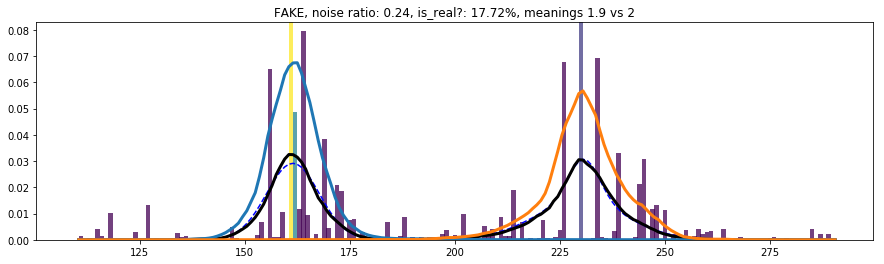

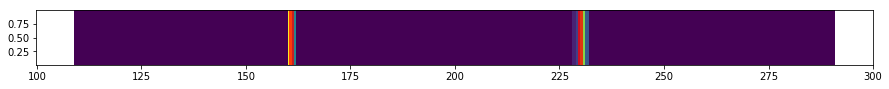

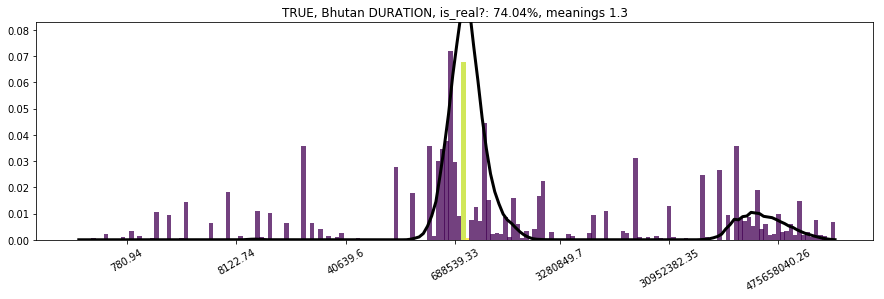

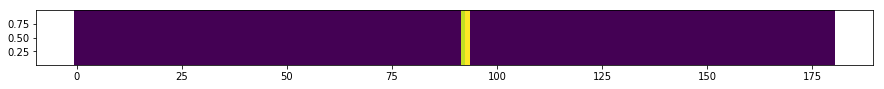

iter: 755, completed: 23.65%, smoother_loss: 1.1260, deconv_loss: 1.3881, smoother_reg: 0.0097, deconv_reg: 0.0191, peaks_loss: 0.8336, mn_loss: 0.1170, ro_pen: 0.0121
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 760, completed: 23.81%, smoother_loss: 1.1260, deconv_loss: 1.3752, smoother_reg: 0.0098, deconv_reg: 0.0191, peaks_loss: 0.8335, mn_loss: 0.1177, ro_pen: 0.0119
Smother | wts: (-14.53, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 765, completed: 23.97%, smoother_loss: 1.1253, deconv_loss: 1.3623, smoother_reg: 0.0096, deconv_reg: 0.0190, peaks_loss: 0.8351, mn_loss: 0.1167, ro_pen: 0.0118
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  413 bins
error with  241 bins
iter: 770, completed: 24.12%, smoother_loss: 1.1243, deconv_loss: 1.3497, smoother_reg: 0.0094, deconv_reg: 0.0189, peaks_loss: 0.8333, mn_loss: 0.1182, ro_pen: 0.0119
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  282 bins
iter: 775, completed: 24.28%, smo

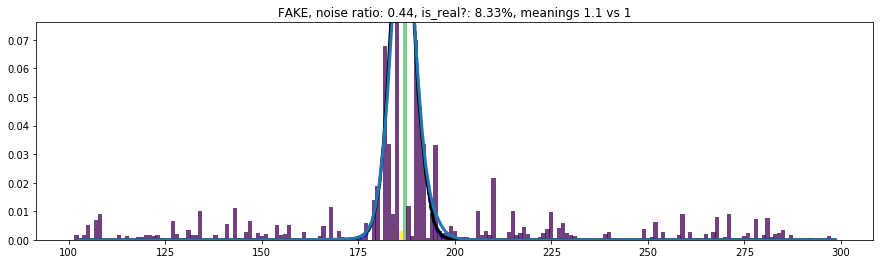

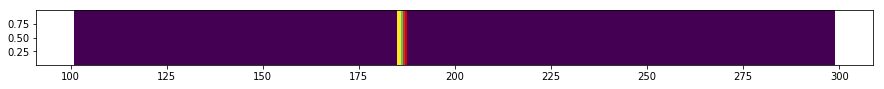

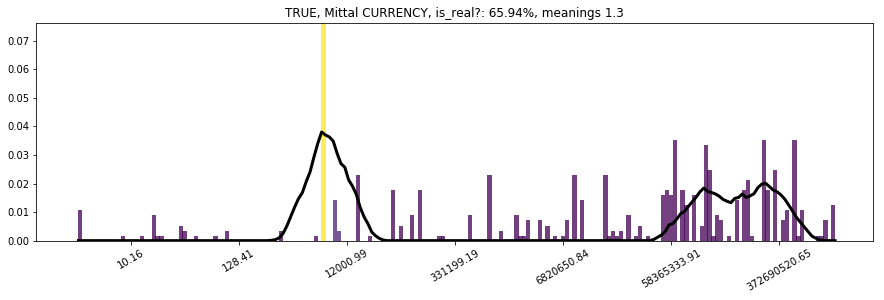

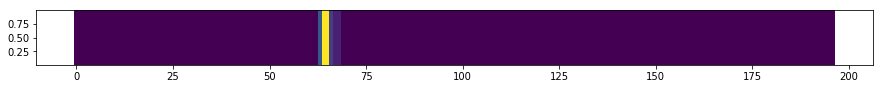

iter: 780, completed: 24.44%, smoother_loss: 1.1274, deconv_loss: 1.3312, smoother_reg: 0.0089, deconv_reg: 0.0188, peaks_loss: 0.8358, mn_loss: 0.1195, ro_pen: 0.0125
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 785, completed: 24.59%, smoother_loss: 1.1279, deconv_loss: 1.3218, smoother_reg: 0.0089, deconv_reg: 0.0187, peaks_loss: 0.8370, mn_loss: 0.1194, ro_pen: 0.0124
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 790, completed: 24.75%, smoother_loss: 1.1233, deconv_loss: 1.3077, smoother_reg: 0.0088, deconv_reg: 0.0186, peaks_loss: 0.8352, mn_loss: 0.1190, ro_pen: 0.0122
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 795, completed: 24.91%, smoother_loss: 1.1212, deconv_loss: 1.2965, smoother_reg: 0.0086, deconv_reg: 0.0186, peaks_loss: 0.8349, mn_loss: 0.1178, ro_pen: 0.0120
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 800, completed: 25.06%, smoother_loss: 1.1234, deconv_loss: 1.2902, smoother_reg: 0.0084, 

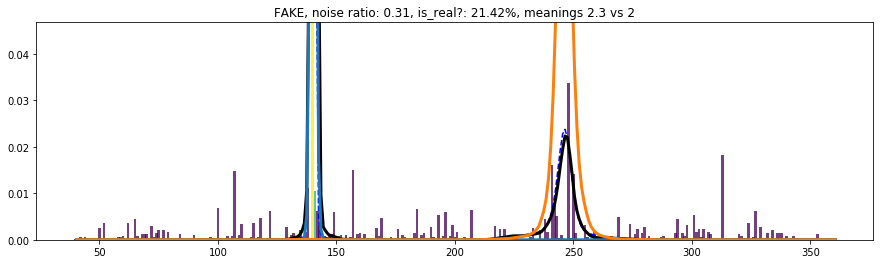

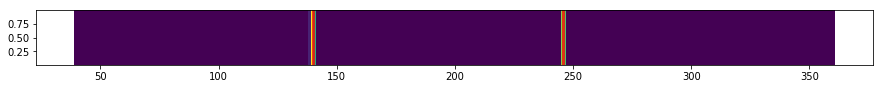

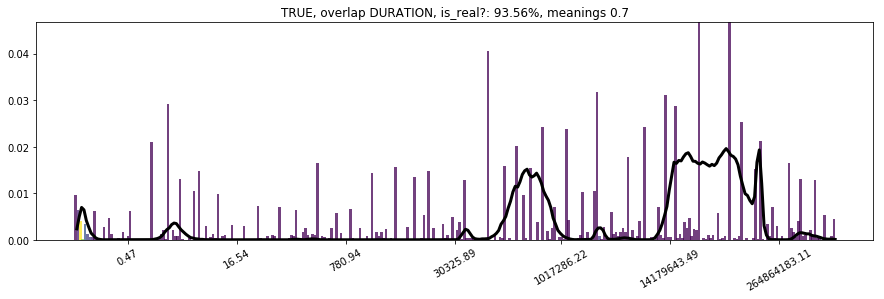

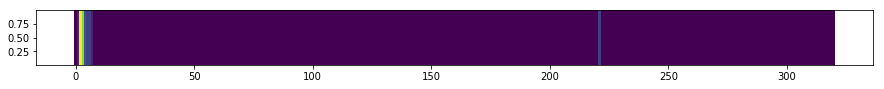

error with  464 bins
iter: 805, completed: 25.22%, smoother_loss: 1.1216, deconv_loss: 1.2802, smoother_reg: 0.0085, deconv_reg: 0.0189, peaks_loss: 0.8353, mn_loss: 0.1163, ro_pen: 0.0120
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 810, completed: 25.38%, smoother_loss: 1.1296, deconv_loss: 1.2804, smoother_reg: 0.0085, deconv_reg: 0.0189, peaks_loss: 0.8386, mn_loss: 0.1213, ro_pen: 0.0119
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 815, completed: 25.53%, smoother_loss: 1.1290, deconv_loss: 1.2724, smoother_reg: 0.0085, deconv_reg: 0.0191, peaks_loss: 0.8375, mn_loss: 0.1227, ro_pen: 0.0119
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 820, completed: 25.69%, smoother_loss: 1.1258, deconv_loss: 1.2622, smoother_reg: 0.0084, deconv_reg: 0.0192, peaks_loss: 0.8349, mn_loss: 0.1225, ro_pen: 0.0117
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 825, completed: 25.84%, smoother_loss: 1.1293, deconv_loss: 1.2590, s

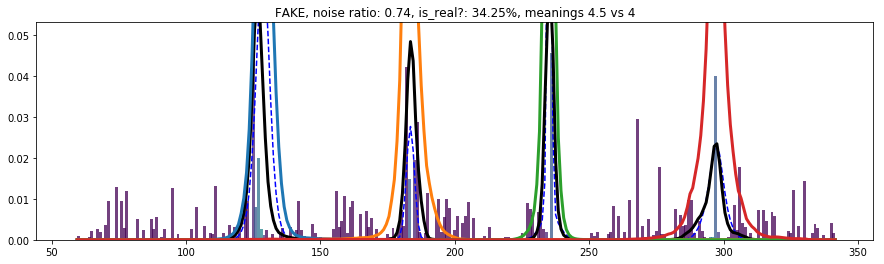

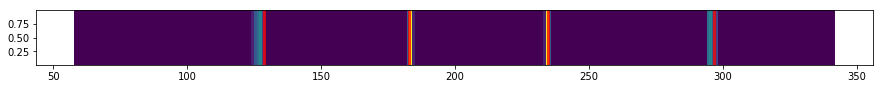

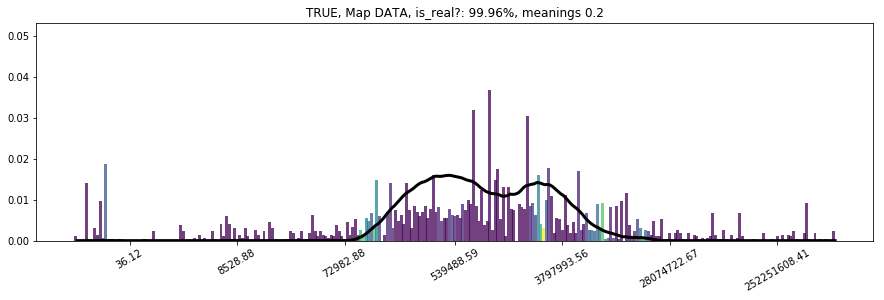

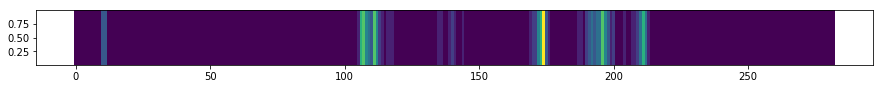

error with  334 bins
iter: 830, completed: 26.00%, smoother_loss: 1.1252, deconv_loss: 1.2485, smoother_reg: 0.0083, deconv_reg: 0.0192, peaks_loss: 0.8362, mn_loss: 0.1214, ro_pen: 0.0114
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  417 bins
iter: 835, completed: 26.16%, smoother_loss: 1.1270, deconv_loss: 1.2442, smoother_reg: 0.0083, deconv_reg: 0.0193, peaks_loss: 0.8361, mn_loss: 0.1214, ro_pen: 0.0115
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  429 bins
iter: 840, completed: 26.31%, smoother_loss: 1.1239, deconv_loss: 1.2355, smoother_reg: 0.0082, deconv_reg: 0.0192, peaks_loss: 0.8343, mn_loss: 0.1212, ro_pen: 0.0115
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 845, completed: 26.47%, smoother_loss: 1.1225, deconv_loss: 1.2286, smoother_reg: 0.0080, deconv_reg: 0.0193, peaks_loss: 0.8334, mn_loss: 0.1205, ro_pen: 0.0115
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 850, completed: 26.63%, smo

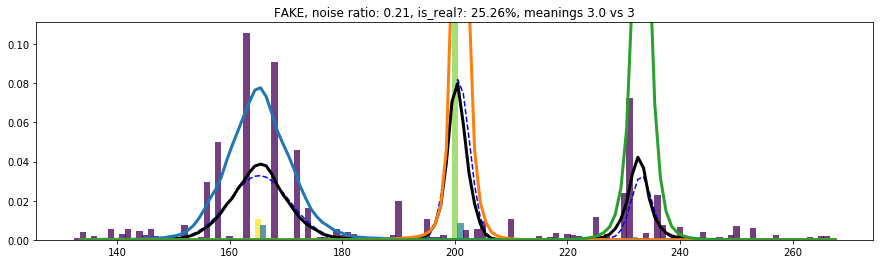

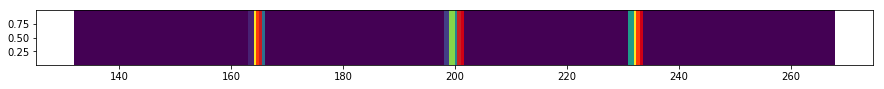

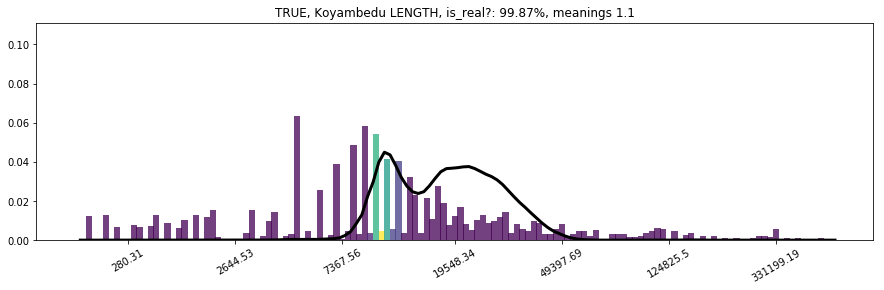

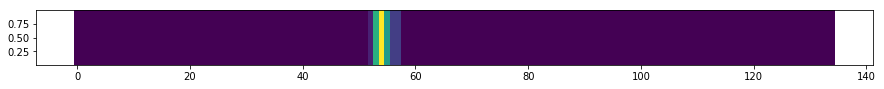

iter: 855, completed: 26.78%, smoother_loss: 1.1213, deconv_loss: 1.2172, smoother_reg: 0.0079, deconv_reg: 0.0190, peaks_loss: 0.8351, mn_loss: 0.1191, ro_pen: 0.0116
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  405 bins
error with  453 bins
iter: 860, completed: 26.94%, smoother_loss: 1.1278, deconv_loss: 1.2191, smoother_reg: 0.0081, deconv_reg: 0.0190, peaks_loss: 0.8403, mn_loss: 0.1196, ro_pen: 0.0119
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 865, completed: 27.10%, smoother_loss: 1.1279, deconv_loss: 1.2146, smoother_reg: 0.0082, deconv_reg: 0.0190, peaks_loss: 0.8384, mn_loss: 0.1202, ro_pen: 0.0117
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  330 bins
iter: 870, completed: 27.25%, smoother_loss: 1.1288, deconv_loss: 1.2113, smoother_reg: 0.0081, deconv_reg: 0.0191, peaks_loss: 0.8400, mn_loss: 0.1195, ro_pen: 0.0117
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 875, completed: 27.41%, smo

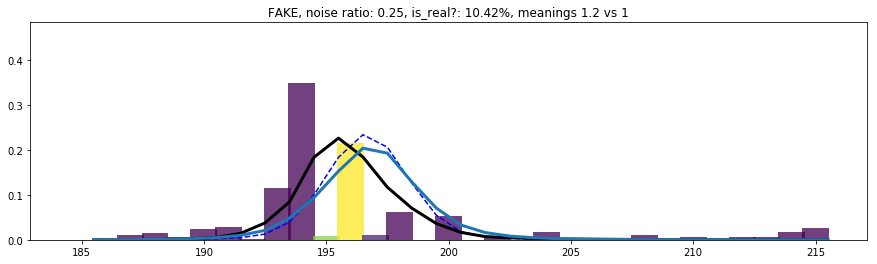

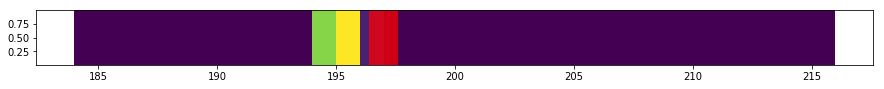

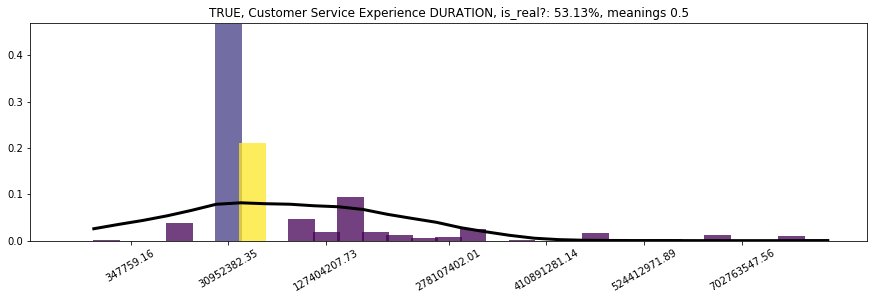

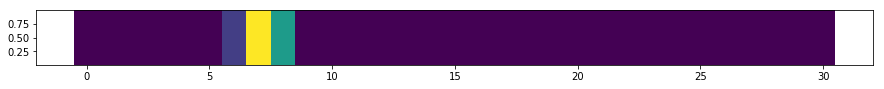

iter: 880, completed: 27.57%, smoother_loss: 1.1277, deconv_loss: 1.2023, smoother_reg: 0.0080, deconv_reg: 0.0189, peaks_loss: 0.8382, mn_loss: 0.1197, ro_pen: 0.0119
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 885, completed: 27.72%, smoother_loss: 1.1315, deconv_loss: 1.2025, smoother_reg: 0.0079, deconv_reg: 0.0188, peaks_loss: 0.8411, mn_loss: 0.1206, ro_pen: 0.0119
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 890, completed: 27.88%, smoother_loss: 1.1302, deconv_loss: 1.1977, smoother_reg: 0.0077, deconv_reg: 0.0187, peaks_loss: 0.8407, mn_loss: 0.1201, ro_pen: 0.0119
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 895, completed: 28.04%, smoother_loss: 1.1500, deconv_loss: 1.2142, smoother_reg: 0.0076, deconv_reg: 0.0188, peaks_loss: 0.8467, mn_loss: 0.1329, ro_pen: 0.0128
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 900, completed: 28.19%, smoother_loss: 1.1565, deconv_loss: 1.2175, smoother_reg: 0.0077, 

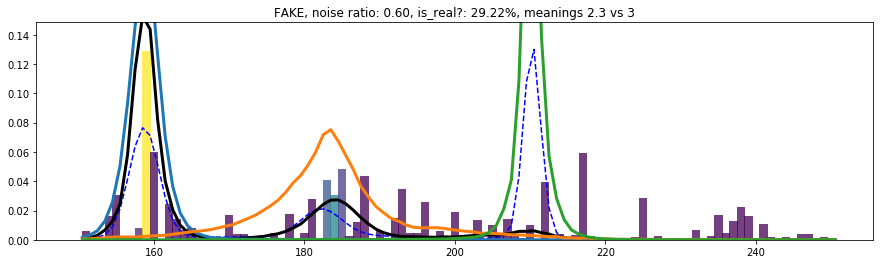

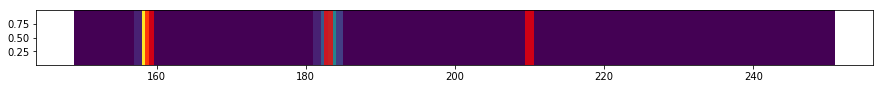

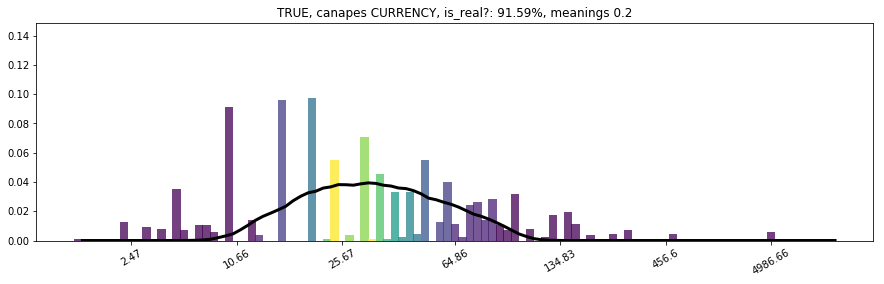

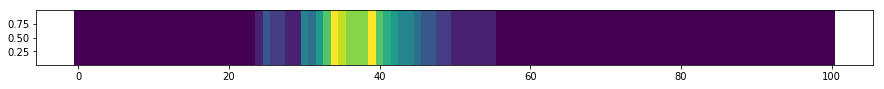

iter: 905, completed: 28.35%, smoother_loss: 1.1554, deconv_loss: 1.2135, smoother_reg: 0.0077, deconv_reg: 0.0188, peaks_loss: 0.8500, mn_loss: 0.1344, ro_pen: 0.0127
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 910, completed: 28.50%, smoother_loss: 1.1507, deconv_loss: 1.2059, smoother_reg: 0.0078, deconv_reg: 0.0188, peaks_loss: 0.8469, mn_loss: 0.1334, ro_pen: 0.0127
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 915, completed: 28.66%, smoother_loss: 1.1471, deconv_loss: 1.1996, smoother_reg: 0.0079, deconv_reg: 0.0188, peaks_loss: 0.8468, mn_loss: 0.1302, ro_pen: 0.0126
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 920, completed: 28.82%, smoother_loss: 1.1508, deconv_loss: 1.2007, smoother_reg: 0.0079, deconv_reg: 0.0187, peaks_loss: 0.8464, mn_loss: 0.1322, ro_pen: 0.0129
Smother | wts: (-14.52, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 925, completed: 28.97%, smoother_loss: 1.1502, deconv_loss: 1.1976, smoother_reg: 0.0079, 

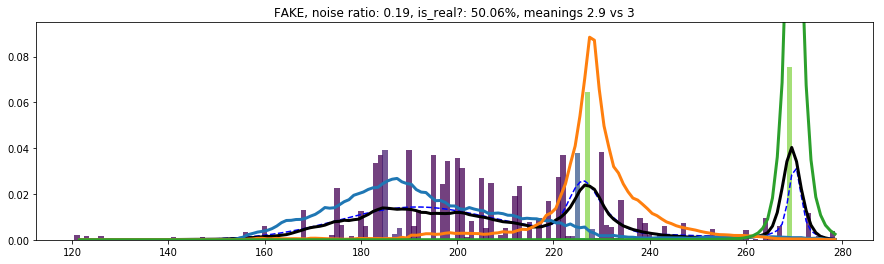

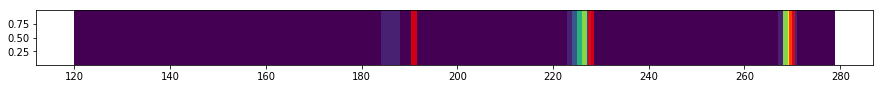

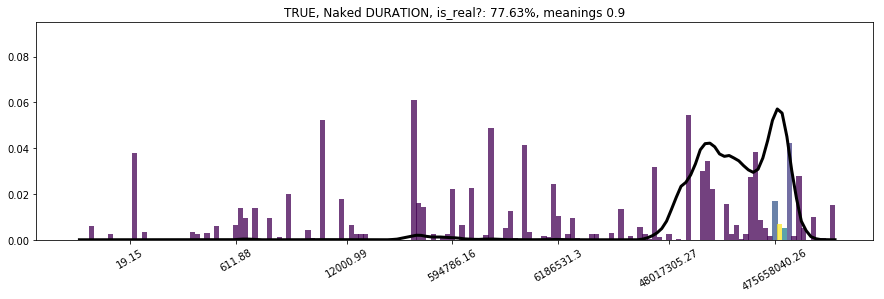

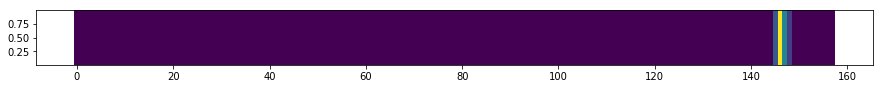

iter: 930, completed: 29.13%, smoother_loss: 1.1496, deconv_loss: 1.1948, smoother_reg: 0.0079, deconv_reg: 0.0186, peaks_loss: 0.8448, mn_loss: 0.1306, ro_pen: 0.0133
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 935, completed: 29.29%, smoother_loss: 1.1475, deconv_loss: 1.1904, smoother_reg: 0.0080, deconv_reg: 0.0187, peaks_loss: 0.8409, mn_loss: 0.1297, ro_pen: 0.0151
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 940, completed: 29.44%, smoother_loss: 1.1473, deconv_loss: 1.1881, smoother_reg: 0.0084, deconv_reg: 0.0188, peaks_loss: 0.8379, mn_loss: 0.1289, ro_pen: 0.0152
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  406 bins
iter: 945, completed: 29.60%, smoother_loss: 1.1444, deconv_loss: 1.1833, smoother_reg: 0.0086, deconv_reg: 0.0189, peaks_loss: 0.8360, mn_loss: 0.1281, ro_pen: 0.0149
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
error with  298 bins
error with  224 bins
error with  172 bins
iter: 950, c

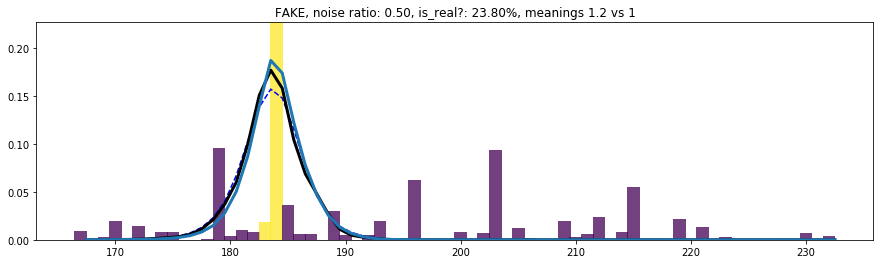

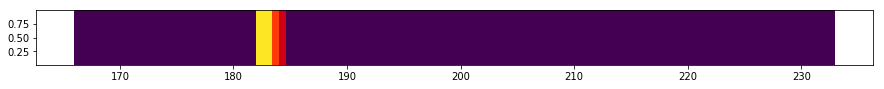

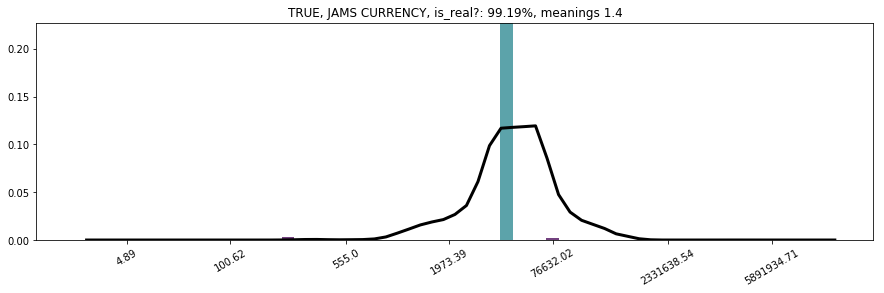

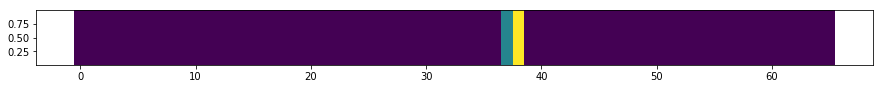

iter: 955, completed: 29.91%, smoother_loss: 1.1472, deconv_loss: 1.1823, smoother_reg: 0.0087, deconv_reg: 0.0188, peaks_loss: 0.8384, mn_loss: 0.1271, ro_pen: 0.0152
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 960, completed: 30.07%, smoother_loss: 1.1437, deconv_loss: 1.1771, smoother_reg: 0.0087, deconv_reg: 0.0189, peaks_loss: 0.8366, mn_loss: 0.1265, ro_pen: 0.0150
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 965, completed: 30.23%, smoother_loss: 1.1433, deconv_loss: 1.1751, smoother_reg: 0.0087, deconv_reg: 0.0188, peaks_loss: 0.8379, mn_loss: 0.1264, ro_pen: 0.0146
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 970, completed: 30.38%, smoother_loss: 1.1347, deconv_loss: 1.1649, smoother_reg: 0.0086, deconv_reg: 0.0188, peaks_loss: 0.8330, mn_loss: 0.1249, ro_pen: 0.0142
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 975, completed: 30.54%, smoother_loss: 1.1347, deconv_loss: 1.1634, smoother_reg: 0.0086, 

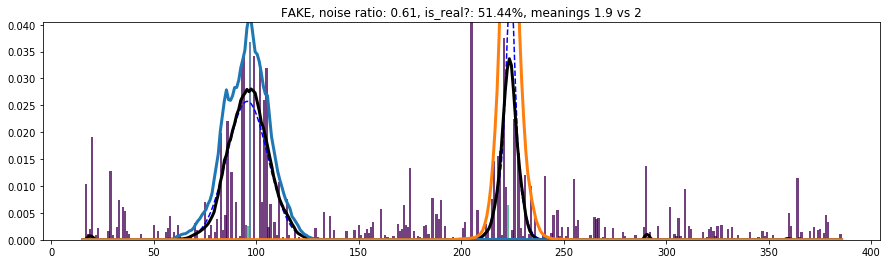

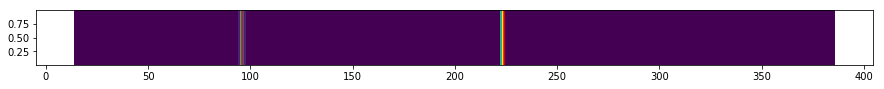

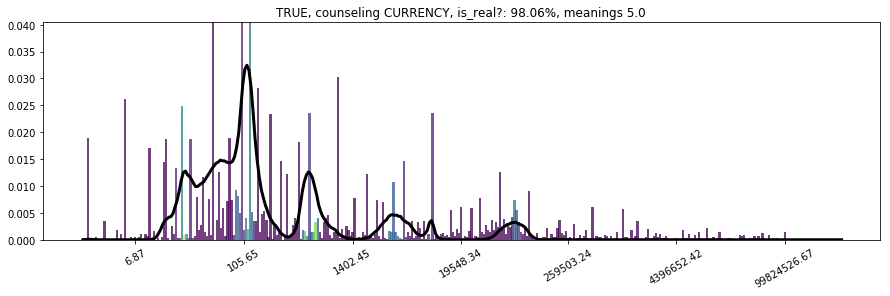

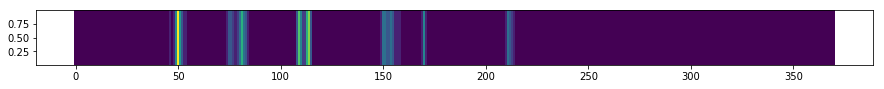

iter: 980, completed: 30.69%, smoother_loss: 1.1352, deconv_loss: 1.1625, smoother_reg: 0.0086, deconv_reg: 0.0187, peaks_loss: 0.8372, mn_loss: 0.1228, ro_pen: 0.0139
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 985, completed: 30.85%, smoother_loss: 1.1337, deconv_loss: 1.1597, smoother_reg: 0.0085, deconv_reg: 0.0187, peaks_loss: 0.8369, mn_loss: 0.1219, ro_pen: 0.0137
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 990, completed: 31.01%, smoother_loss: 1.1296, deconv_loss: 1.1543, smoother_reg: 0.0085, deconv_reg: 0.0186, peaks_loss: 0.8342, mn_loss: 0.1217, ro_pen: 0.0135
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 995, completed: 31.16%, smoother_loss: 1.1277, deconv_loss: 1.1512, smoother_reg: 0.0086, deconv_reg: 0.0186, peaks_loss: 0.8342, mn_loss: 0.1195, ro_pen: 0.0134
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.76, 1.38)
iter: 1000, completed: 31.32%, smoother_loss: 1.1275, deconv_loss: 1.1498, smoother_reg: 0.0088,

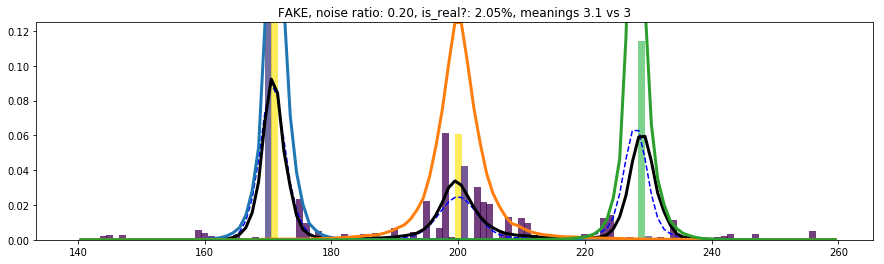

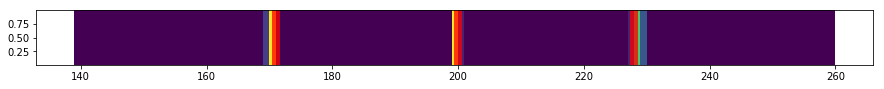

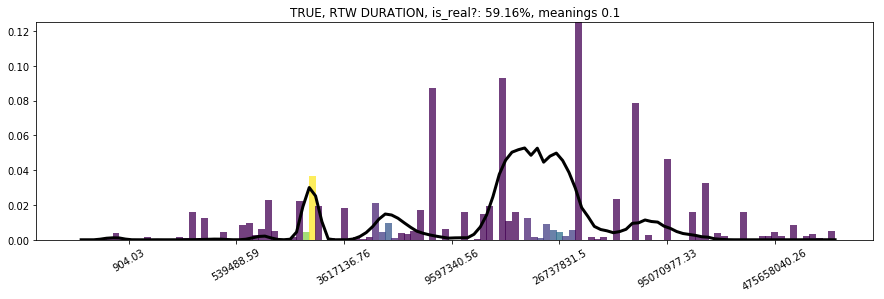

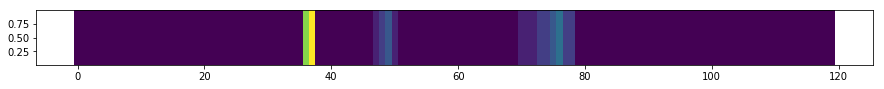

iter: 1005, completed: 31.48%, smoother_loss: 1.1272, deconv_loss: 1.1485, smoother_reg: 0.0088, deconv_reg: 0.0187, peaks_loss: 0.8357, mn_loss: 0.1174, ro_pen: 0.0135
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.77, 1.38)
error with  432 bins
iter: 1010, completed: 31.63%, smoother_loss: 1.1229, deconv_loss: 1.1431, smoother_reg: 0.0087, deconv_reg: 0.0185, peaks_loss: 0.8340, mn_loss: 0.1152, ro_pen: 0.0136
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.77, 1.38)
error with  308 bins
error with  313 bins
error with  416 bins
iter: 1015, completed: 31.79%, smoother_loss: 1.1211, deconv_loss: 1.1403, smoother_reg: 0.0087, deconv_reg: 0.0186, peaks_loss: 0.8336, mn_loss: 0.1142, ro_pen: 0.0132
Smother | wts: (-14.51, 2.29)
Deconv | wts: (-4.77, 1.38)
error with  223 bins
iter: 1020, completed: 31.95%, smoother_loss: 1.1216, deconv_loss: 1.1399, smoother_reg: 0.0086, deconv_reg: 0.0185, peaks_loss: 0.8335, mn_loss: 0.1151, ro_pen: 0.0131
Smother | wts: (-14.51, 2.29)
Deconv | wts: (

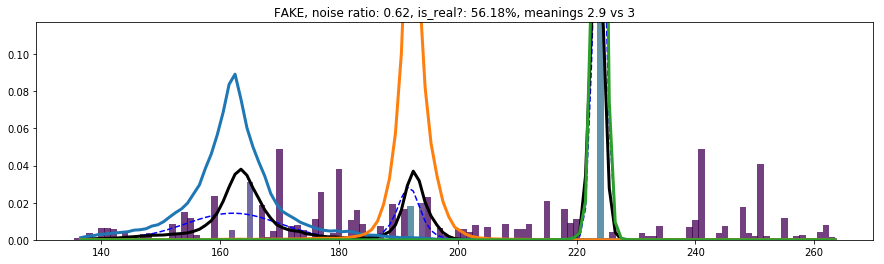

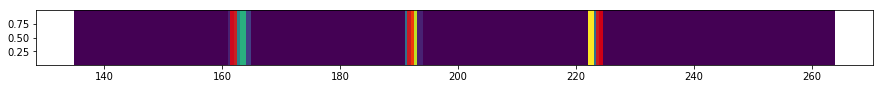

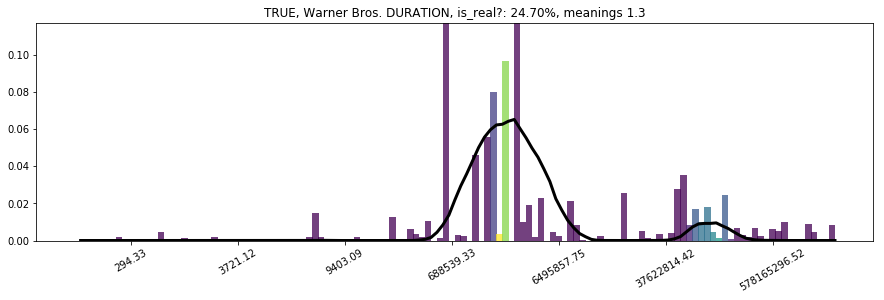

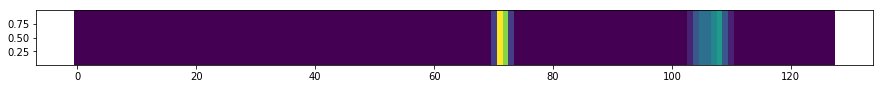

iter: 1030, completed: 32.26%, smoother_loss: 1.1151, deconv_loss: 1.1316, smoother_reg: 0.0087, deconv_reg: 0.0185, peaks_loss: 0.8321, mn_loss: 0.1127, ro_pen: 0.0126
Smother | wts: (-14.50, 2.29)
Deconv | wts: (-4.77, 1.38)
iter: 1035, completed: 32.42%, smoother_loss: 1.1155, deconv_loss: 1.1313, smoother_reg: 0.0087, deconv_reg: 0.0185, peaks_loss: 0.8333, mn_loss: 0.1116, ro_pen: 0.0125
Smother | wts: (-14.50, 2.29)
Deconv | wts: (-4.77, 1.38)
error with  456 bins
iter: 1040, completed: 32.57%, smoother_loss: 1.1170, deconv_loss: 1.1319, smoother_reg: 0.0087, deconv_reg: 0.0184, peaks_loss: 0.8337, mn_loss: 0.1130, ro_pen: 0.0124
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1045, completed: 32.73%, smoother_loss: 1.1180, deconv_loss: 1.1322, smoother_reg: 0.0086, deconv_reg: 0.0187, peaks_loss: 0.8326, mn_loss: 0.1142, ro_pen: 0.0126
Smother | wts: (-14.50, 2.29)
Deconv | wts: (-4.77, 1.38)
iter: 1050, completed: 32.88%, smoother_loss: 1.1198, deconv_loss: 1.13

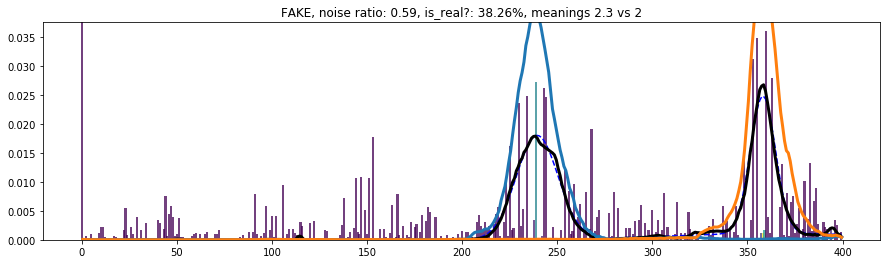

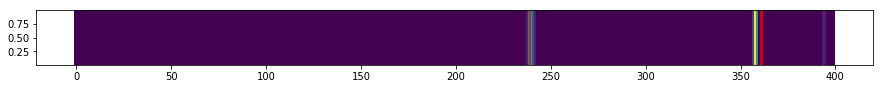

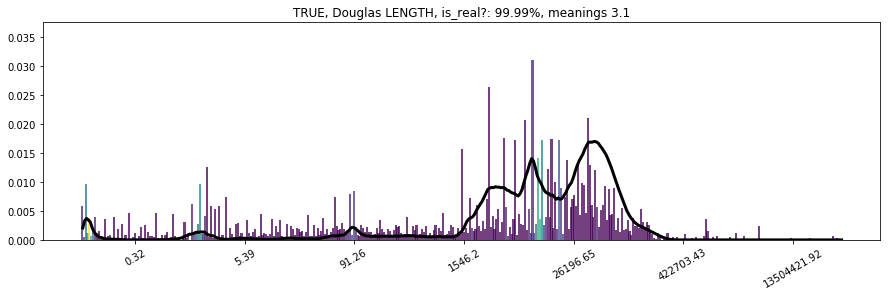

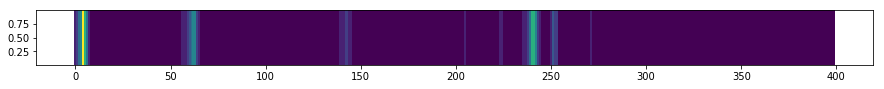

error with  431 bins
error with  302 bins
iter: 1055, completed: 33.04%, smoother_loss: 1.1165, deconv_loss: 1.1294, smoother_reg: 0.0084, deconv_reg: 0.0187, peaks_loss: 0.8330, mn_loss: 0.1135, ro_pen: 0.0121
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
error with  418 bins
iter: 1060, completed: 33.20%, smoother_loss: 1.1124, deconv_loss: 1.1246, smoother_reg: 0.0082, deconv_reg: 0.0189, peaks_loss: 0.8300, mn_loss: 0.1128, ro_pen: 0.0121
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1065, completed: 33.35%, smoother_loss: 1.1187, deconv_loss: 1.1303, smoother_reg: 0.0082, deconv_reg: 0.0190, peaks_loss: 0.8321, mn_loss: 0.1143, ro_pen: 0.0122
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1070, completed: 33.51%, smoother_loss: 1.1240, deconv_loss: 1.1351, smoother_reg: 0.0083, deconv_reg: 0.0189, peaks_loss: 0.8342, mn_loss: 0.1154, ro_pen: 0.0129
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1075, completed: 33.67%

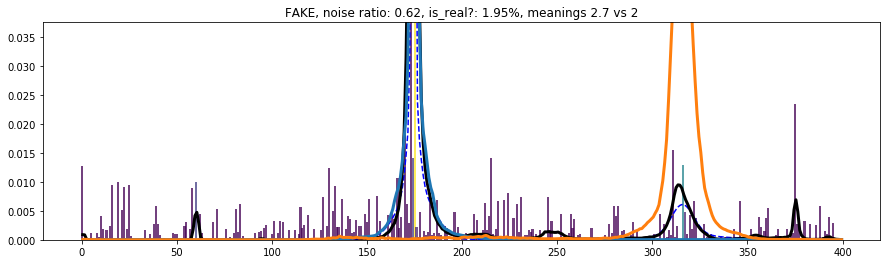

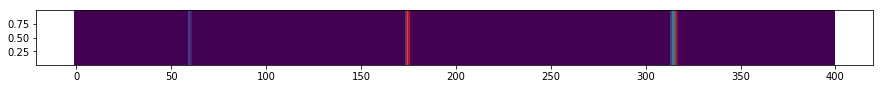

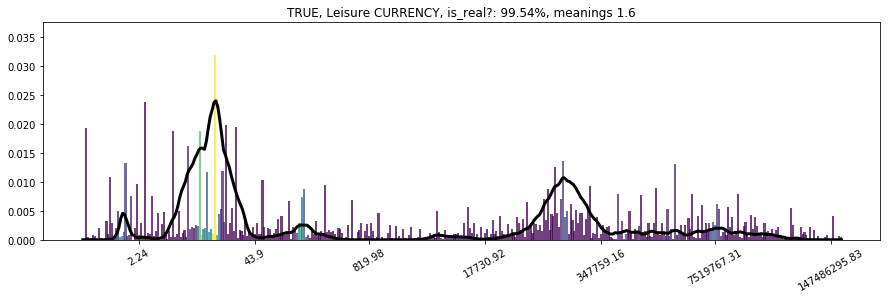

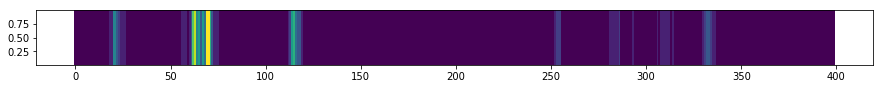

iter: 1080, completed: 33.82%, smoother_loss: 1.1339, deconv_loss: 1.1438, smoother_reg: 0.0094, deconv_reg: 0.0189, peaks_loss: 0.8374, mn_loss: 0.1183, ro_pen: 0.0128
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1085, completed: 33.98%, smoother_loss: 1.1365, deconv_loss: 1.1460, smoother_reg: 0.0094, deconv_reg: 0.0188, peaks_loss: 0.8400, mn_loss: 0.1190, ro_pen: 0.0126
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1090, completed: 34.14%, smoother_loss: 1.1335, deconv_loss: 1.1426, smoother_reg: 0.0094, deconv_reg: 0.0188, peaks_loss: 0.8376, mn_loss: 0.1192, ro_pen: 0.0126
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
error with  344 bins
iter: 1095, completed: 34.29%, smoother_loss: 1.1355, deconv_loss: 1.1441, smoother_reg: 0.0093, deconv_reg: 0.0189, peaks_loss: 0.8405, mn_loss: 0.1187, ro_pen: 0.0124
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
error with  440 bins
iter: 1100, completed: 34.45%, smoother_loss: 1.13

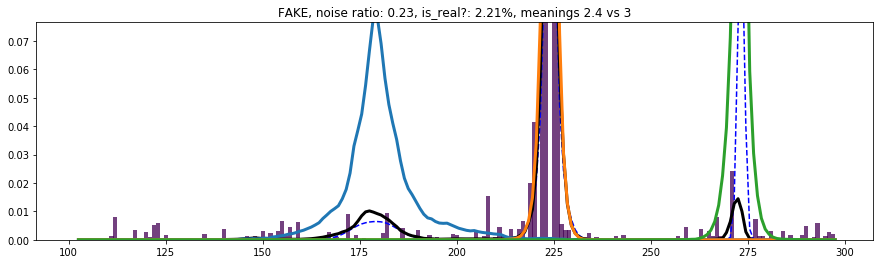

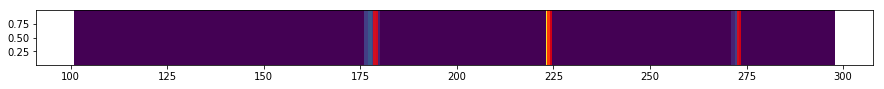

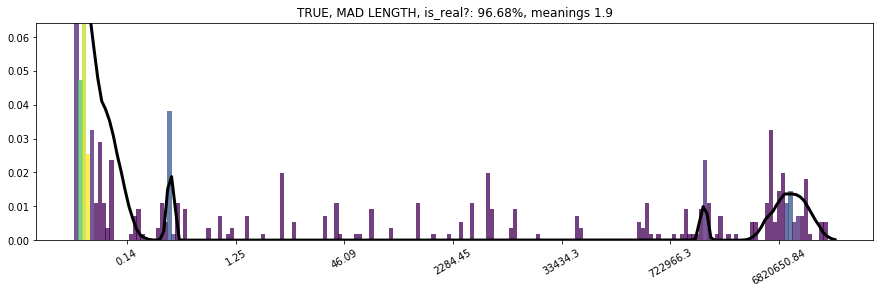

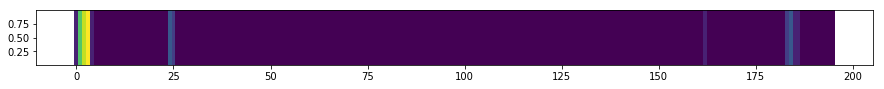

error with  281 bins
iter: 1105, completed: 34.61%, smoother_loss: 1.1349, deconv_loss: 1.1426, smoother_reg: 0.0093, deconv_reg: 0.0191, peaks_loss: 0.8377, mn_loss: 0.1198, ro_pen: 0.0121
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
error with  408 bins
 smoother grad : Tensor had NaN values
	 [[node CheckNumerics_144 (defined at C:\Users\garci\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_train_step_1123259]

Function call stack:
train_step

file  ../SmoothDoQ/doq_noun_batches/000348.json
iter: 1110, completed: 34.76%, smoother_loss: 1.1300, deconv_loss: 1.1373, smoother_reg: 0.0092, deconv_reg: 0.0192, peaks_loss: 0.8331, mn_loss: 0.1198, ro_pen: 0.0121
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1115, completed: 34.92%, smoother_loss: 1.1275, deconv_loss: 1.1346, smoother_reg: 0.0091, deconv_reg: 0.0190, peaks_loss: 0.8332, mn_loss: 0.1188, ro_pen: 0.0121
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4

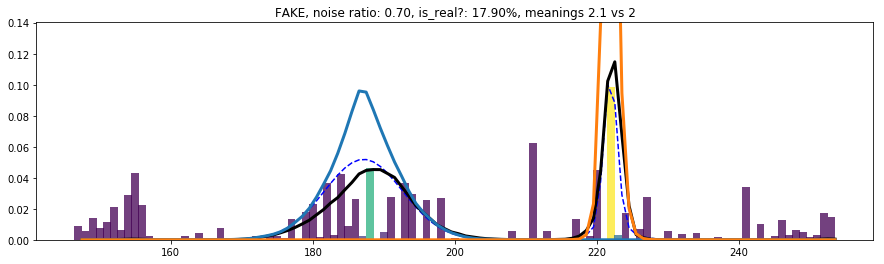

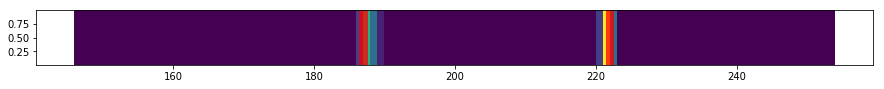

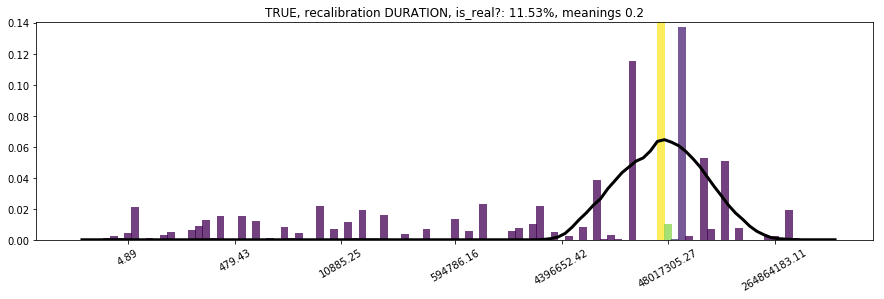

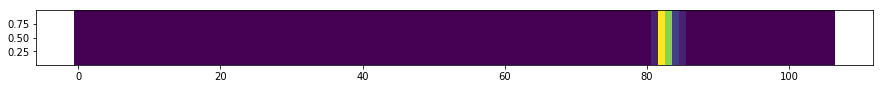

iter: 1130, completed: 35.39%, smoother_loss: 1.1306, deconv_loss: 1.1367, smoother_reg: 0.0087, deconv_reg: 0.0190, peaks_loss: 0.8311, mn_loss: 0.1255, ro_pen: 0.0133
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
error with  371 bins
iter: 1135, completed: 35.54%, smoother_loss: 1.1329, deconv_loss: 1.1387, smoother_reg: 0.0088, deconv_reg: 0.0188, peaks_loss: 0.8323, mn_loss: 0.1276, ro_pen: 0.0132
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1140, completed: 35.70%, smoother_loss: 1.1294, deconv_loss: 1.1349, smoother_reg: 0.0088, deconv_reg: 0.0188, peaks_loss: 0.8316, mn_loss: 0.1260, ro_pen: 0.0133
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1145, completed: 35.86%, smoother_loss: 1.1286, deconv_loss: 1.1338, smoother_reg: 0.0088, deconv_reg: 0.0187, peaks_loss: 0.8317, mn_loss: 0.1254, ro_pen: 0.0131
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
error with  341 bins
iter: 1150, completed: 36.01%, smoother_loss: 1.12

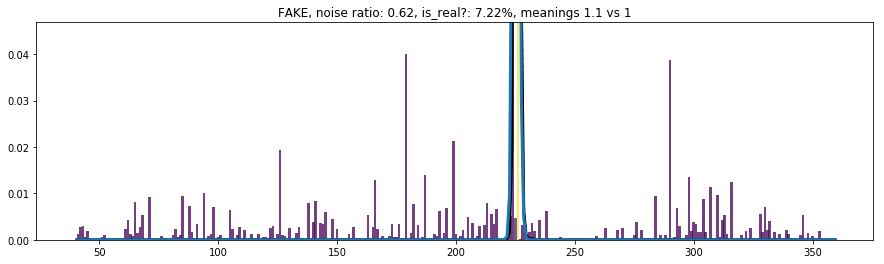

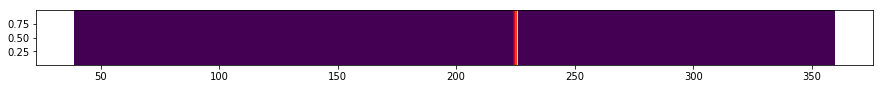

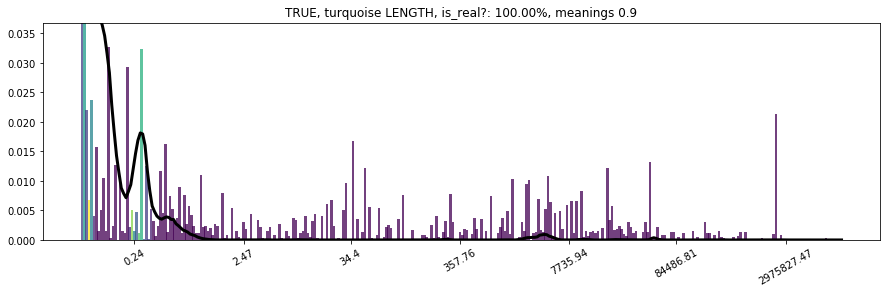

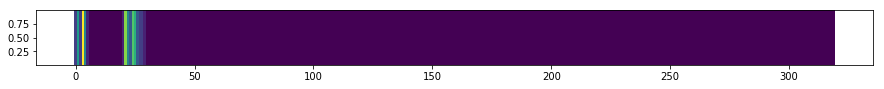

iter: 1155, completed: 36.17%, smoother_loss: 1.1277, deconv_loss: 1.1324, smoother_reg: 0.0086, deconv_reg: 0.0186, peaks_loss: 0.8301, mn_loss: 0.1274, ro_pen: 0.0130
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
error with  321 bins
 smoother grad : Tensor had NaN values
	 [[node CheckNumerics_144 (defined at C:\Users\garci\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_train_step_1123259]

Function call stack:
train_step

file  ../SmoothDoQ/doq_noun_batches/001804.json
error with  252 bins
iter: 1160, completed: 36.33%, smoother_loss: 1.1250, deconv_loss: 1.1295, smoother_reg: 0.0085, deconv_reg: 0.0189, peaks_loss: 0.8267, mn_loss: 0.1271, ro_pen: 0.0134
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1165, completed: 36.48%, smoother_loss: 1.1184, deconv_loss: 1.1226, smoother_reg: 0.0085, deconv_reg: 0.0190, peaks_loss: 0.8223, mn_loss: 0.1253, ro_pen: 0.0132
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4

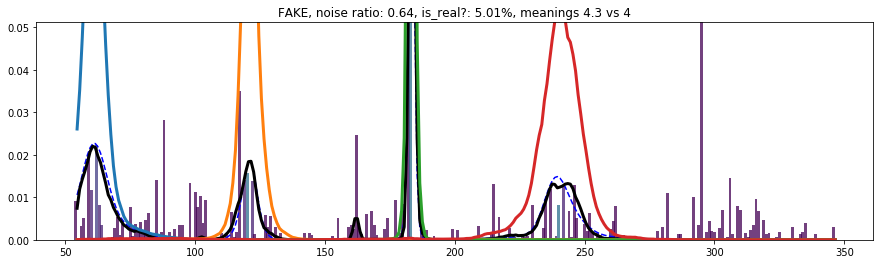

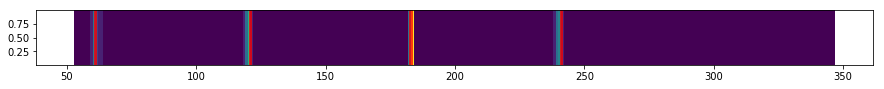

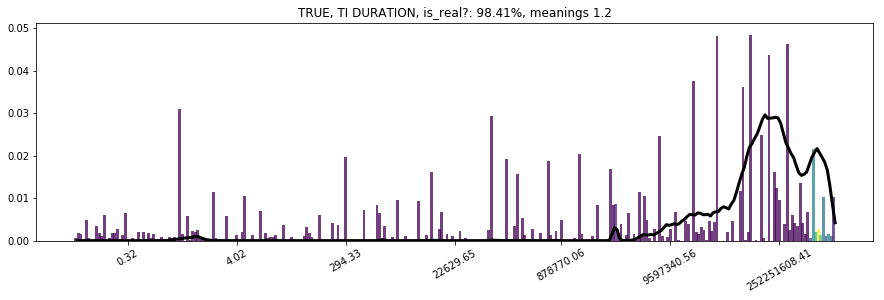

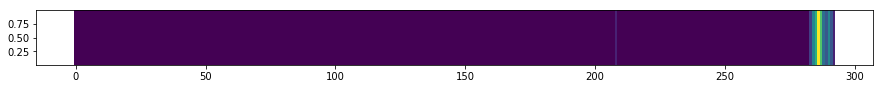

error with  237 bins
iter: 1180, completed: 36.95%, smoother_loss: 1.1186, deconv_loss: 1.1222, smoother_reg: 0.0083, deconv_reg: 0.0187, peaks_loss: 0.8262, mn_loss: 0.1242, ro_pen: 0.0126
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1185, completed: 37.11%, smoother_loss: 1.1184, deconv_loss: 1.1219, smoother_reg: 0.0082, deconv_reg: 0.0185, peaks_loss: 0.8304, mn_loss: 0.1223, ro_pen: 0.0123
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1190, completed: 37.27%, smoother_loss: 1.1169, deconv_loss: 1.1202, smoother_reg: 0.0082, deconv_reg: 0.0184, peaks_loss: 0.8308, mn_loss: 0.1211, ro_pen: 0.0124
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
error with  357 bins
iter: 1195, completed: 37.42%, smoother_loss: 1.1173, deconv_loss: 1.1205, smoother_reg: 0.0081, deconv_reg: 0.0187, peaks_loss: 0.8320, mn_loss: 0.1201, ro_pen: 0.0123
Smother | wts: (-14.50, 2.28)
Deconv | wts: (-4.77, 1.38)
iter: 1200, completed: 37.58%, smoother_loss: 1.11

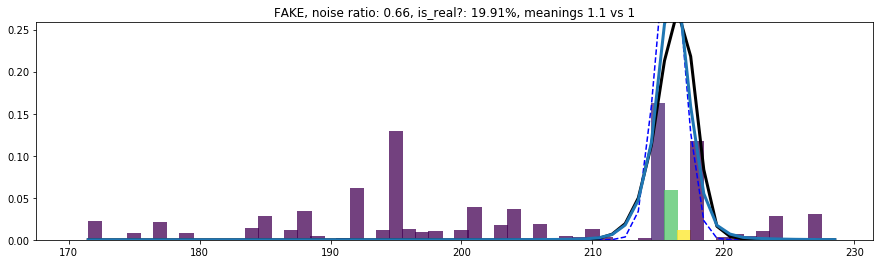

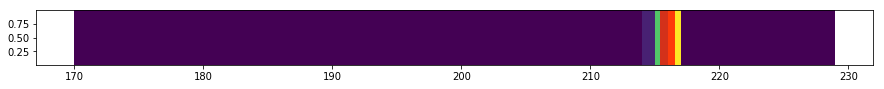

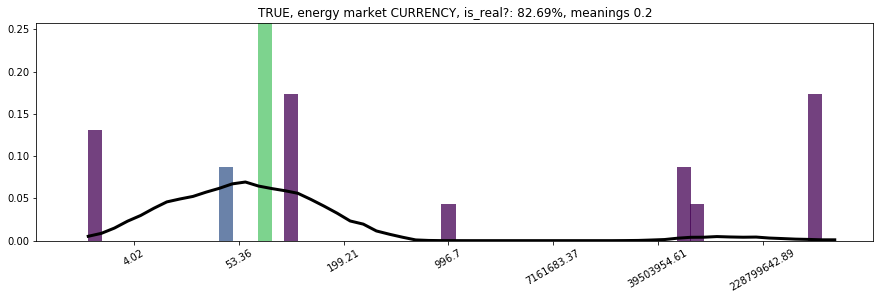

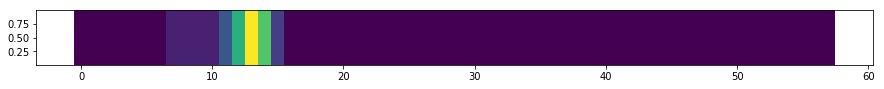

error with  367 bins
error with  292 bins
iter: 1205, completed: 37.73%, smoother_loss: 1.1301, deconv_loss: 1.1330, smoother_reg: 0.0081, deconv_reg: 0.0184, peaks_loss: 0.8366, mn_loss: 0.1257, ro_pen: 0.0127
Smother | wts: (-14.49, 2.28)
Deconv | wts: (-4.78, 1.38)
iter: 1210, completed: 37.89%, smoother_loss: 1.1376, deconv_loss: 1.1403, smoother_reg: 0.0080, deconv_reg: 0.0185, peaks_loss: 0.8403, mn_loss: 0.1284, ro_pen: 0.0127
Smother | wts: (-14.49, 2.28)
Deconv | wts: (-4.78, 1.38)
error with  476 bins
iter: 1215, completed: 38.05%, smoother_loss: 1.1352, deconv_loss: 1.1378, smoother_reg: 0.0081, deconv_reg: 0.0182, peaks_loss: 0.8391, mn_loss: 0.1275, ro_pen: 0.0128
Smother | wts: (-14.49, 2.28)
Deconv | wts: (-4.78, 1.38)
error with  350 bins
error with  357 bins
error with  357 bins
iter: 1220, completed: 38.20%, smoother_loss: 1.1306, deconv_loss: 1.1330, smoother_reg: 0.0083, deconv_reg: 0.0183, peaks_loss: 0.8358, mn_loss: 0.1258, ro_pen: 0.0126
Smother | wts: (-14.49, 

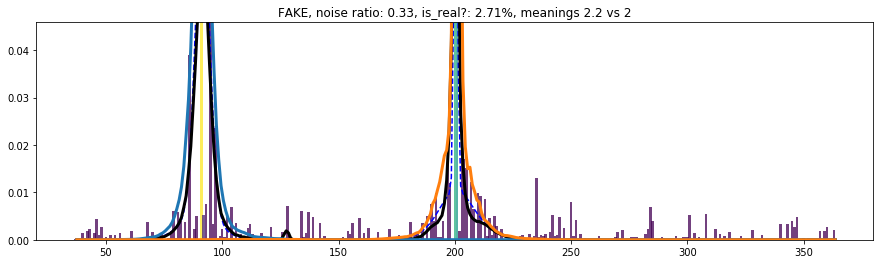

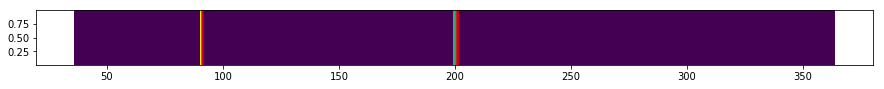

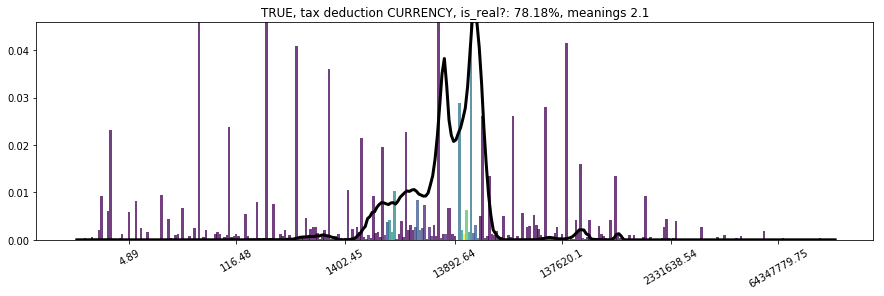

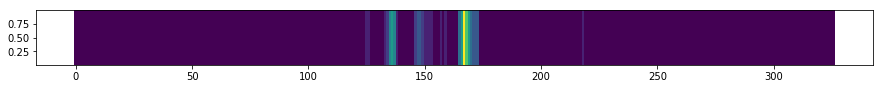

KeyboardInterrupt: 

In [14]:
print_every = 5
plot_every = 25
save_every = 100
save_ckpt = 1000
# num_ckpt = 0
num_ckpt = 300
lam = 0.01
epochs = 2
entries_per_file = 64
batches_per_file = entries_per_file // BATCHSIZE
total_iter = batches_per_file * len(files)
np.random.shuffle(files)


for epoch in range(epochs):
    print(f"===== Epoch {epoch}: =====")
    i = 0
    for file in files:
        file_data = read_batch(file)
        np.random.shuffle(file_data)
        for b in range(batches_per_file):
            batch = file_data[b*BATCHSIZE:(b + 1)*BATCHSIZE]
            if len(batch) < BATCHSIZE:
#                 print(f"Skipping batch {b} from file {file}")
                continue
            x, z, s, nr, modes, bs, x_stacked, s_stacked, modes_stacked, bs_stacked, num_meanings, generated_images, generated_images_stacked = get_inputs(batch)
            x_ = tf.convert_to_tensor(x, tf.float32)
            z_ = tf.convert_to_tensor(z, tf.float32)
            s_ = tf.convert_to_tensor(s, tf.float32)
            nr_ = tf.convert_to_tensor(nr, tf.float32)
            modes_ = tf.convert_to_tensor(modes, tf.float32)
            bs_ = tf.convert_to_tensor(bs, tf.float32)
            x_stacked_ = tf.convert_to_tensor(x_stacked, tf.float32)
            s_stacked_ = tf.convert_to_tensor(s_stacked, tf.float32)
            modes_stacked_ = tf.convert_to_tensor(modes_stacked, tf.float32)
            bs_stacked_ = tf.convert_to_tensor(bs_stacked, tf.float32)
            nm_ = tf.convert_to_tensor(np.reshape(num_meanings, (-1, 1)), tf.float32)
            gi_ = tf.convert_to_tensor(generated_images, tf.float32)
            gi_stacked_ = tf.convert_to_tensor(generated_images_stacked, tf.float32)
            try:
                sm_loss, deconv_loss, sm_reg, deconv_reg, peaks_loss, mn_loss, ro_pen = train_step(
                    x_, z_, s_, nr_, modes_, bs_, gi_, nm_, x_stacked_, s_stacked_, modes_stacked_, bs_stacked_, gi_stacked_)
            except tf.errors.InvalidArgumentError as e:
                print(e)
                print("file ", file)
#                 print("x row sum: ", np.sum(np.squeeze(x), 1))
#                 print("x row min", np.min(np.squeeze(x), 1))
#                 print("x row max", np.max(np.squeeze(x), 1))
#                 print("x na?", np.any(np.squeeze(np.isnan(x)), 1))
                
                continue

            # record losses
            if not first_run:
                sm_loss_ += lam * (sm_loss.numpy() - sm_loss_)
                deconv_loss_ += lam * (sm_loss.numpy() - deconv_loss_)
                sm_reg_ += lam * (sm_reg.numpy() - sm_reg_)
                deconv_reg_ += lam * (deconv_reg.numpy() - deconv_reg_)
                peaks_loss_ += lam * (peaks_loss.numpy() - peaks_loss_)
                mn_loss_ += lam * (mn_loss.numpy() - mn_loss_)
                ro_pen_ += lam * (ro_pen.numpy() - ro_pen_)                
            else:
                sm_loss_ = sm_loss.numpy()
                deconv_loss_ = deconv_loss.numpy()
                sm_reg_ = sm_reg.numpy()
                deconv_reg_ = deconv_reg.numpy()
                peaks_loss_ = peaks_loss.numpy()
                mn_loss_ = mn_loss.numpy()
                ro_pen_ = ro_pen.numpy()
                first_run = False
                
            # print
            if i % print_every == 0:
                fr = f"iter: {i}, completed: {100.0 * (i + 1) / total_iter:.2f}%"
                sl = f"smoother_loss: {sm_loss_:.4f}"
                dl = f"deconv_loss: {deconv_loss_:.4f}"
                slr = f"smoother_reg: {sm_reg_:.4f}"
                dlr = f"deconv_reg: {deconv_reg_:.4f}"
                pl = f"peaks_loss: {peaks_loss_:.4f}"
                ml = f"mn_loss: {mn_loss_:.4f}"
                rl = f"ro_pen: {ro_pen_:.4f}"
                msg = f"{fr}, {sl}, {dl}, {slr}, {dlr}, {pl}, {ml}, {rl}"
                print(msg)
                print_checks(smoother, "Smother")
                print_checks(deconv, "Deconv")
            

            if i % plot_every == 0:
                obs, start = standardize_bins(batch[0]["counts"])
                n_bins = len(batch[0]["counts"])
                x0 = np.expand_dims(x[0, :, :], 0).astype(np.float32)
                modes_ = np.squeeze(modes[0, :, :]).astype(np.float32)
                modes_locs = np.where(modes_ > 0.0)[0]
                z0 = np.expand_dims(z[0, :, :], 0).astype(np.float32)
                s0 = np.expand_dims(s[0, :, :], 0).astype(np.float32)
                nr0 = np.expand_dims(nr[0, :, :], 0).astype(np.float32)
                b0 = np.expand_dims(bs_[0, :, :], 0).astype(np.float32)
                pdf = np.squeeze(s0)        
                pdf_normalized = s0 * b0  # np.sqrt(b0)
                fake = generator([z0, pdf_normalized, nr0], training=False)
                fake_normalized = fake * b0  # np.sqrt(b0)
                pred, peaks = smoother(fake_normalized, training=False)
                fake = np.squeeze(fake.numpy())
                pred = np.squeeze(pred.numpy())
                peaks = np.squeeze(peaks.numpy())
                peaks = 1.0 / (1.0 + np.exp(-peaks))
                if np.any(np.isnan(fake)) or np.any(np.isnan(peaks)) or np.any(np.isnan(pred)):
                    pdb.set_trace()
                in_range = np.where(fake > 1e-3)[0]
#                 h = np.arange(in_range[0], in_range[-1])
#                 h = np.arange(0, MAXBINS)
                h = np.arange(start, min(MAXBINS, start + n_bins))
                # FAKE IMAGE
                plt.figure(figsize=(15, 4))
                bcol = (peaks[h] - min(peaks[h])) / (max(peaks[h]) - min(peaks[h]))
                plt.bar(h, fake[h], width=1.1, alpha=0.75, color=viridis(bcol))
                plt.plot(h + 0.5, pdf[h], c="blue", ls="dashed")
                plt.plot(h + 0.5, pred[h], c="black", lw=3)
                u = pred[h]
                plt.ylim(0, 15 * np.mean(u[u > 0]))
                discat = discriminator(fake_normalized, training=False)
                discat = discat.numpy().item()
                discat = 1.0 / (1.0 + np.exp(-discat))
                pred_meanings = sum(peaks)
                true_meanings = num_meanings[0]
                leg_meanings = f"meanings {pred_meanings:.1f} vs {true_meanings}"
                plt.title(f"FAKE, noise ratio: {nr0[0,0,0]:.2f}, is_real?: {100 * discat:.2f}%, {leg_meanings}")
                # add contexts
                for v, mm in enumerate(modes_locs):
                    u = np.zeros((1, MAXBINS, 1), dtype=np.float32)
                    u[0, mm, 0] = 1.0
                    u = np.concatenate([fake_normalized, u], -1)
                    dec_output = np.squeeze(deconv(u).numpy())
                    plt.plot(h + 0.5, dec_output[h], lw=3)                    
                plt.show()
                plt.figure(figsize=(15, 1))
                plt.bar(h, np.ones_like(h), width=2.0, alpha=1.0, color=viridis(bcol))
                plt.ylim(0.01, 0.99)
                plt.bar(modes_locs, np.ones_like(modes_locs), width=1.2, color="red", alpha=0.75)
                plt.show()
                # REAL IMAGE
                plt.figure(figsize=(15, 4))
                x_normalized = x0 * b0  # np.sqrt(b0)
                pred, peaks = smoother(x_normalized, training=False)
                pred = np.squeeze(pred.numpy())
                peaks = np.squeeze(peaks.numpy())
                peaks = 1.0 / (1.0 + np.exp(-peaks))
                real = np.squeeze(x0)
                in_range = np.where(real > 1e-3)[0]
                h0 = np.arange(len(h))
                bcol = (peaks[h] - min(peaks[h])) / (max(peaks[h]) - min(peaks[h]))
                plt.bar(h0, real[h], width=1.1, alpha=0.75, color=viridis(bcol))
                plt.plot(h0 + 0.5, pred[h], c="black", lw=3)
                u = pred[h]
                plt.ylim(0, 15 * np.mean(u[u > 0]))
                discat = discriminator(x_normalized, training=False).numpy().item()
                discat = 1.0 / (1.0 + np.exp(-discat))
                obj = batch[0]['obj']
                dim = batch[0]['dim']
                pred_meanings = sum(peaks)
                leg_meanings = f"meanings {pred_meanings:.1f}"
                plt.title(f"TRUE, {obj} {dim}, is_real?: {100 * discat:.2f}%, {leg_meanings}")
                locs = [int((i + 0.5) * (n_bins - 1)) // 7 for i in range(7)]
                middle = 0.5 * (np.array(batch[0]['loglower']) + np.array(batch[0]['logupper']))
                labs = [np.round(10 ** middle[j], 2) for j in locs]
                plt.xticks(locs, labs, rotation=30)
                plt.show()
                plt.figure(figsize=(15, 1))
                plt.bar(h0, np.ones_like(h), width=1.0, alpha=1.0, color=viridis(bcol))
                plt.ylim(0.01, 0.99)
                plt.show()


            if (i + 1) % save_every == 0:
                smoother.save_weights("smoother_post_gan2.h5")
                deconv.save_weights("deconv_post_gan2.h5")
                
            if (i + 1) % save_ckpt == 0:
                fname_g = f"ckpts2/smoother_post_gan_{num_ckpt:04d}.h5"
                smoother.save_weights(fname_g)
                fname_d = f"ckpts2/deconv_post_gan_{num_ckpt:04d}.h5"
                deconv.save_weights(fname_d)
                num_ckpt += 1
                
            i += 1
            

In [ ]:
for w in smoother.weights:
    if np.any(np.isnan(w.numpy())):
        print(w.name)

In [77]:
first_run = True